In [1]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import utils as utils
# Set my plot theme
# See here for more detials
# https://github.com/RishiSadhir/rethinking2/blob/master/utils/plotting.py
utils.set_theme()
COLOR = "#2A0933"

In [2]:
%load_ext jupyterstan

# 5.1 - Spurious association

Two variables seem to be associated with a state's divorce rate: Marriage Rate and Age at Marriage. Lets train two different regressions to check it out.

**Python code 5.1**

In [3]:
# Python code 5.1 and 5.2
d = utils.data_from_R("WaffleDivorce", "rethinking")
d2 = (d[['Divorce', 'Marriage', 'MedianAgeMarriage']]
 .apply(utils.standardize))
d2.describe()

Divorce      Marriage  MedianAgeMarriage
count  5.000000e+01  5.000000e+01       5.000000e+01
mean  -3.330669e-16 -1.163514e-15       3.876899e-15
std    1.010153e+00  1.010153e+00       1.010153e+00
min   -1.990553e+00 -1.759167e+00      -2.318193e+00
25%   -7.700357e-01 -7.950029e-01      -5.921384e-01
50%    3.439641e-02 -1.101142e-01      -1.250882e-01
75%    6.723943e-01  5.282288e-01       5.653337e-01
max    2.114824e+00  2.815624e+00       2.961504e+00

To this point, we've tried to make our stan programs as small as possible. Then we'd run a bunch of stuff outside of STAN to think through our model. From now on, we're going to try and shift that complexity to STAN. In particular, we're going to have stan perform our:
    
    1. Prior predictive checks (Predict using priors)
    2. Retrospective predictions (Predict on training data)
    3. Posterior predictions (Predict on "new data")
    
We perform (1) by wrapping the likelihood portion of the model in an if-statement. We can pass in a parameter (prior_only) to ignore the likelihood. We calculate (2) and (3) in the generated quantities block - A new part of our stan programs that run after all the sampling is complete.

Finally, we no longer have two separate stan programs for the two regressions, instead we abstract the y ~ x relationship a bit and use it twice.

**Python code 5.3**

In [4]:
%%stan m_5_1
data{
  int N;
  vector[N] x;
  vector[N] y;
  int prior_only;
  int new_N;
  vector[new_N] new_x;
}
parameters {
  real alpha;
  real beta;
  real<lower=0> sigma;
}
model {
  alpha ~ normal(0, .2);
  beta ~ normal(0, .5);
  sigma ~ exponential(1);
  if (!prior_only) {
      y ~ normal(alpha + beta * x, sigma);
  }
}
generated quantities {
  vector[N] muhat;
  vector[N] yhat;
  vector[new_N] mupred;
  vector[new_N] ypred;
  
  for (i in 1:N) {
    muhat[i] = alpha + beta* x[i];
    yhat[i] = normal_rng(muhat[i], sigma);
  }
  
  for (i in 1:new_N) {
    mupred[i] = alpha + beta* new_x[i];
    ypred[i] = normal_rng(mupred[i], sigma);
  }
}

INFO:pystan:COMPILING THE C++ CODE FOR MODEL m_5_1_4502a2845a6abcdee1eaadb623e0ad8d NOW.


Creating pystan model & assigning it to variable name "m_5_1".
Stan options:
 {'model_name': 'm_5_1', 'include_paths': None, 'boost_lib': None, 'eigen_lib': None, 'verbose': False, 'obfuscate_model_name': True}
StanModel now available as variable "m_5_1"!
Compilation took 45 seconds.


Lets use this code to run a prior predictive check. Notice, all we have to do is pass in `prior_only=1`.

**Python code 5.2 through 5.5 and figure 5.3**

In [5]:
xseq = np.linspace(min(d2['MedianAgeMarriage']),
                   max(d2['MedianAgeMarriage']),
                   1000)
d_dict = {
    "N": len(d2.index),
    "x": d2['MedianAgeMarriage'].values,
    "y": d2["Divorce"].values,
    "prior_only": 1,
    "new_N": 1000,
    "new_x": xseq}

fit_ap = m_5_1.sampling(d_dict, chains = 4, n_jobs = 4)
print(fit_ap.stansummary(pars = ['alpha','beta','sigma'], 
                      probs = [.05, .95]))

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Inference for Stan model: m_5_1_4502a2845a6abcdee1eaadb623e0ad8d.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd     5%    95%  n_eff   Rhat
alpha   0.01  3.3e-3    0.2  -0.32   0.33   3481    1.0
beta    0.01  8.7e-3   0.52  -0.83   0.86   3565    1.0
sigma   1.02    0.02   1.01   0.05   3.01   3975    1.0

Samples were drawn using NUTS at Sat 18 Apr 2020 03:24:18 PM .
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


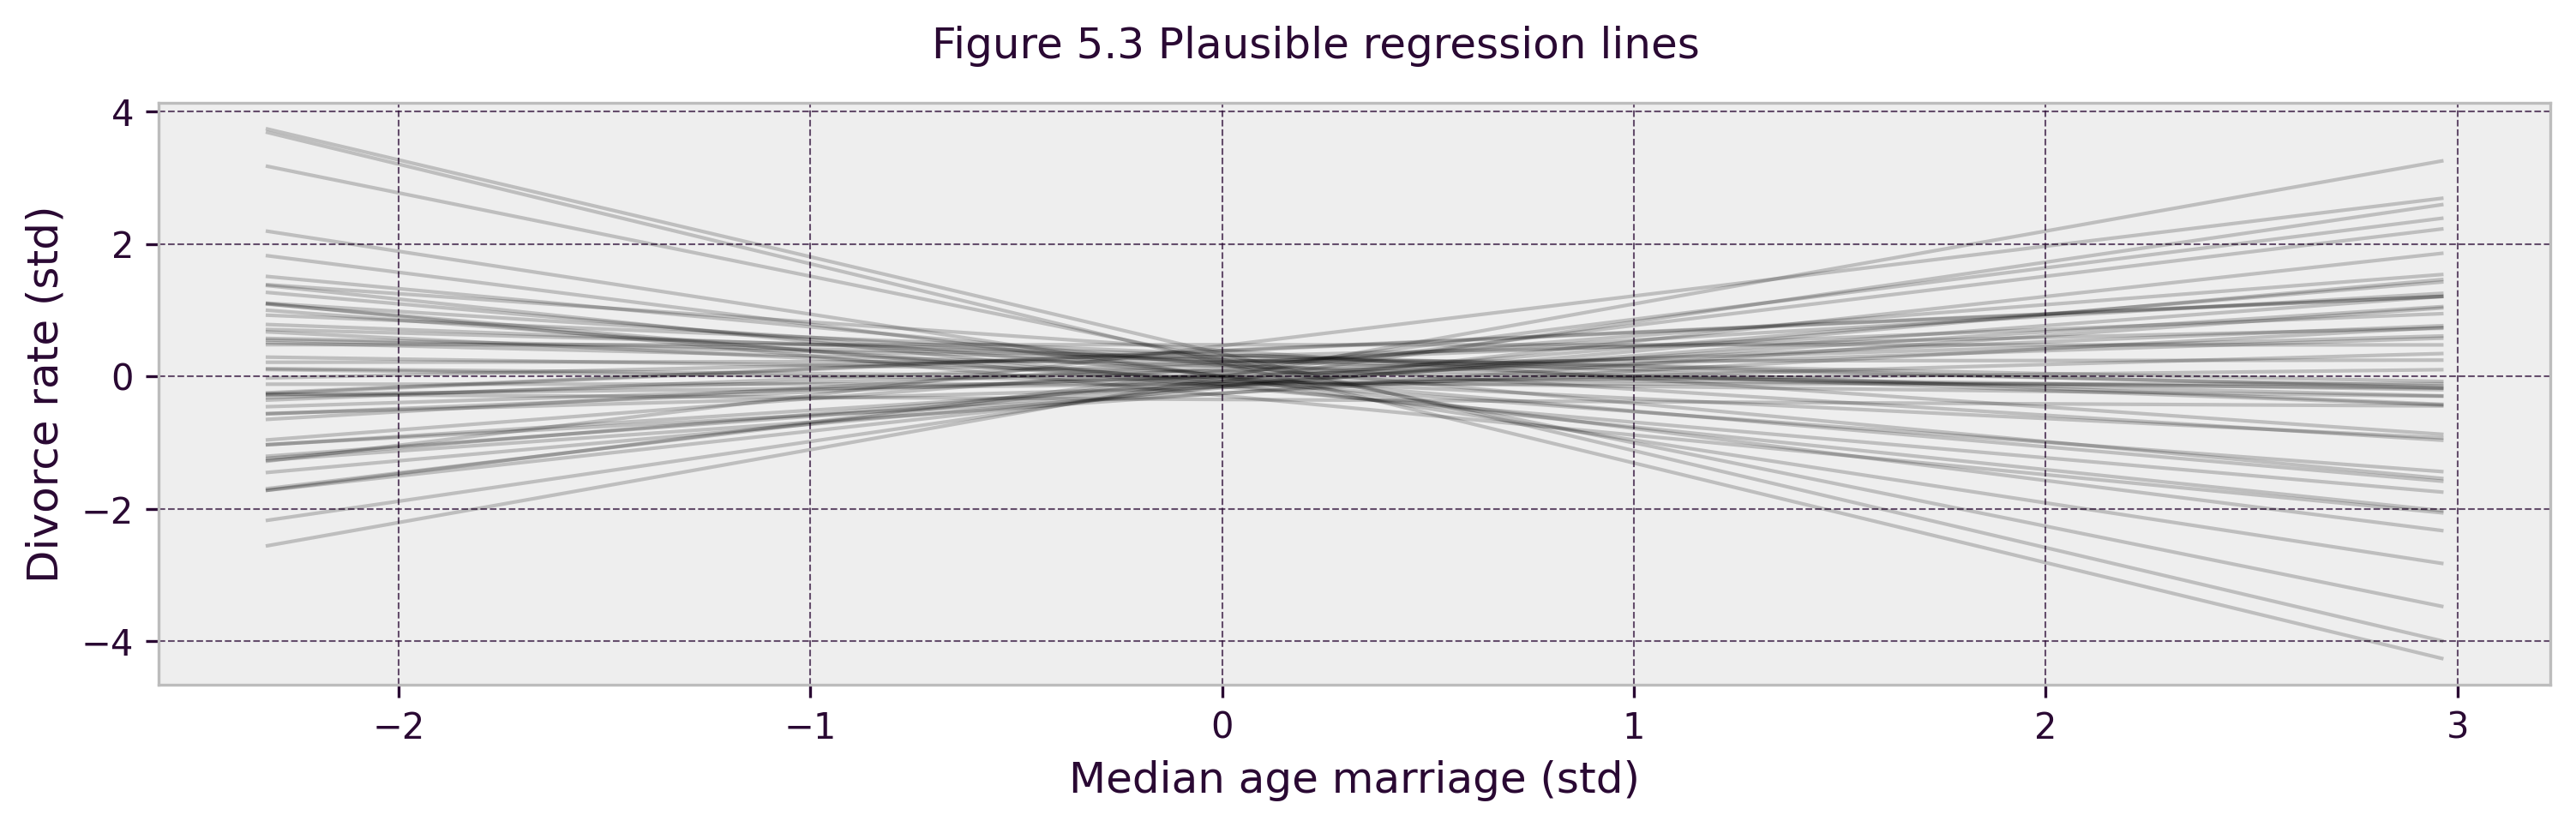

In [6]:
mupred = fit_ap.extract()['mupred']

# Setup plot
fig, ax = plt.subplots(figsize = (12, 3))
ax.set_xlabel("Median age marriage (std)")
ax.set_ylabel("Divorce rate (std)")

# Sample 50 parameters combinations
N = 50
idx = np.random.choice(range(mupred.shape[0]), N)

# Plot their implied mus vs weights
for i in idx:
    ax.plot(xseq, mupred[i,:], color = "black", linewidth=1, alpha=.2)
plt.suptitle("Figure 5.3 Plausible regression lines")    
plt.show()

Now lets run it with the real data. One with marriage rate as the independent variable and one with age as the independent variable
**Python code 5.6 and figure 5.2**

In [7]:
d_dict["prior_only"] = 0
fit_a = m_5_1.sampling(d_dict, chains = 4, n_jobs = 4)
print(fit_a.stansummary(pars = ['alpha','beta','sigma'], 
                      probs = [.05, .95]))

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Inference for Stan model: m_5_1_4502a2845a6abcdee1eaadb623e0ad8d.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd     5%    95%  n_eff   Rhat
alpha -1.9e-3  1.7e-3    0.1  -0.17   0.16   3403    1.0
beta    -0.57  2.0e-3   0.12  -0.75  -0.37   3407    1.0
sigma    0.83  1.4e-3   0.09    0.7   0.99   3600    1.0

Samples were drawn using NUTS at Sat 18 Apr 2020 03:24:19 PM .
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [8]:
d_dict["x"] = d2["Marriage"]
fit_m = m_5_1.sampling(d_dict, chains = 4, n_jobs = 4)
print(fit_m.stansummary(pars = ['alpha','beta','sigma'], 
                      probs = [.05, .95]))

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Inference for Stan model: m_5_1_4502a2845a6abcdee1eaadb623e0ad8d.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd     5%    95%  n_eff   Rhat
alpha -5.3e-3  1.8e-3   0.11  -0.19   0.18   4048    1.0
beta     0.35  2.2e-3   0.13   0.12   0.56   3684    1.0
sigma    0.96  1.6e-3    0.1   0.81   1.13   3899    1.0

Samples were drawn using NUTS at Sat 18 Apr 2020 03:24:20 PM .
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


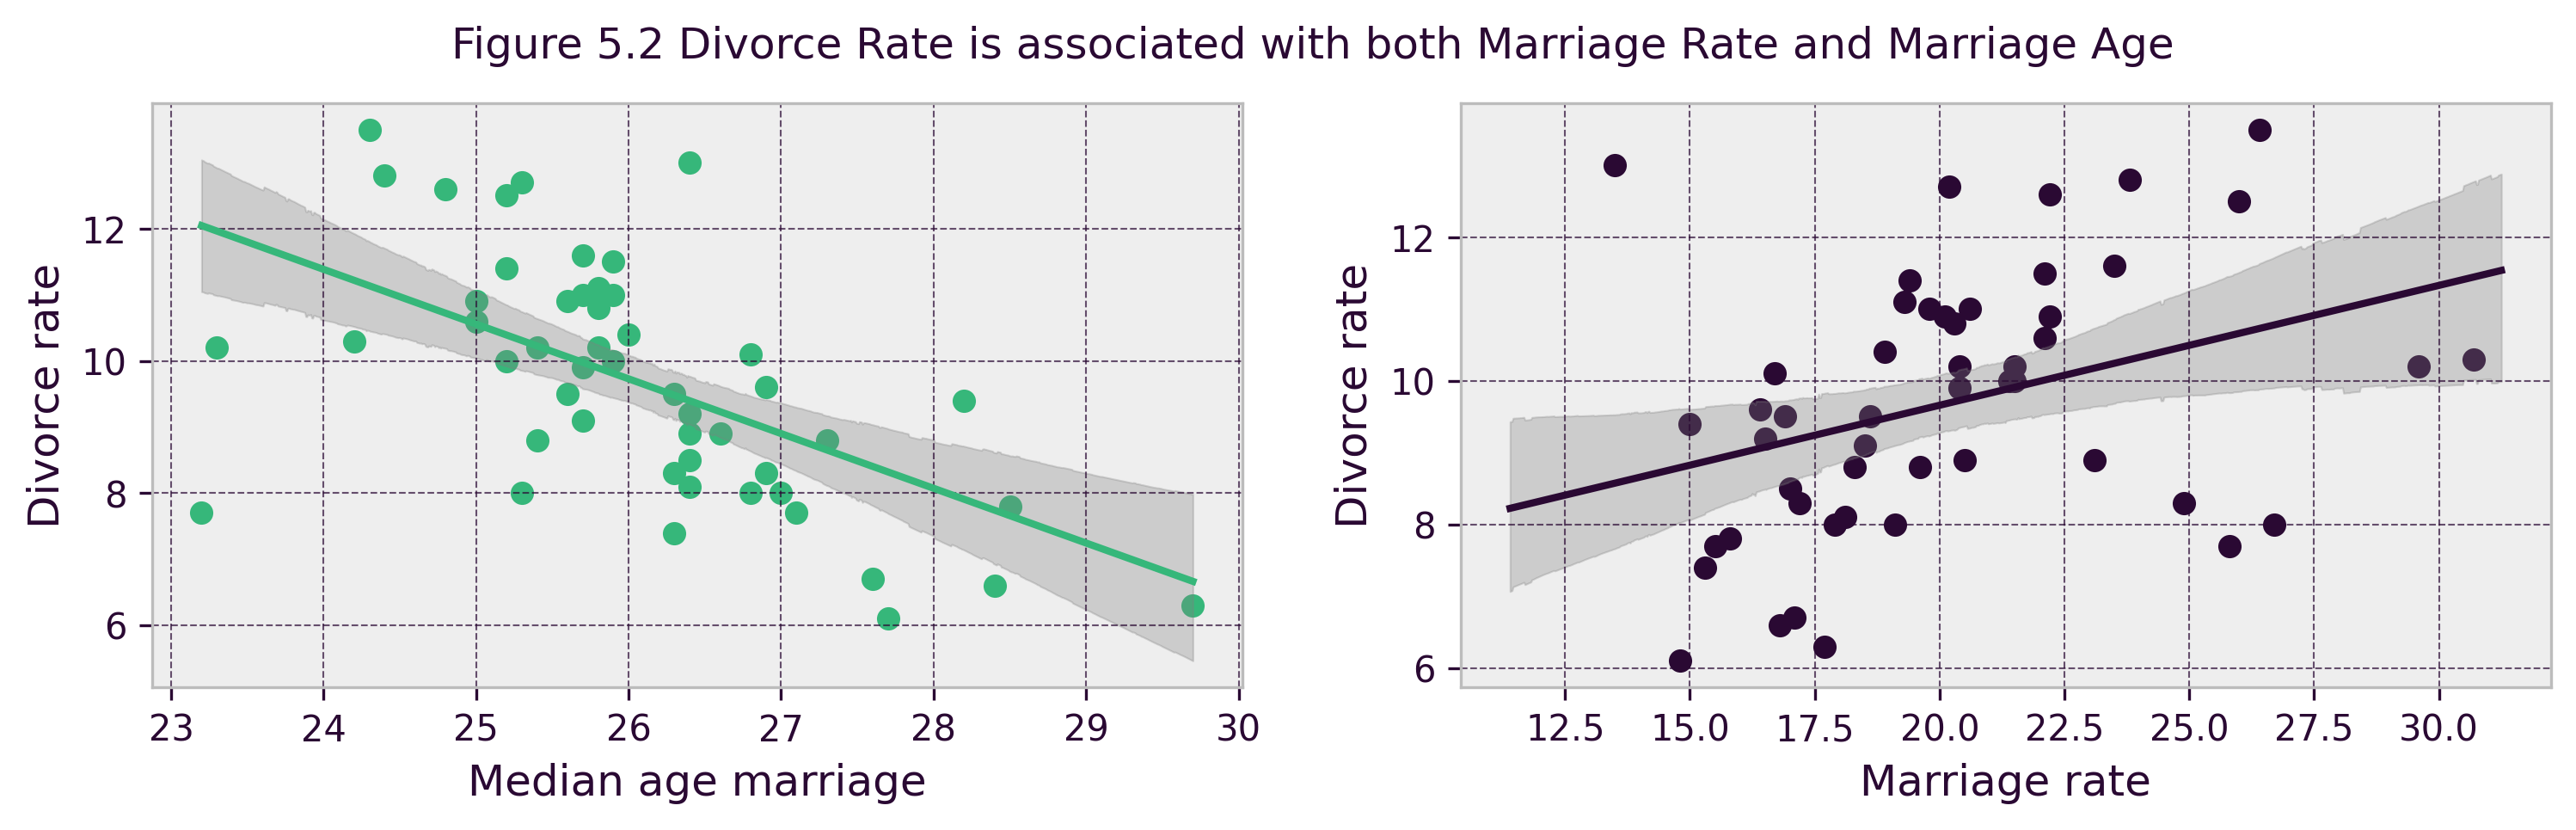

In [9]:
fig, axes = plt.subplots(figsize = (12, 3), ncols = 2)

# Marriage Rate
mupred = fit_m.extract()['mupred']
m_mupred = np.array([np.mean(m) for m in np.transpose(mupred)])
shade_mupred = np.array([utils.hpdi(m) for m in np.transpose(mupred)])
# Unstandardized
y = utils.unstandardize(m_mupred, d['Divorce'])
y_shade = shade_mupred * np.std(d['Divorce']) + np.mean(d['Divorce'])
x = utils.unstandardize(xseq, d["Marriage"])
axes[1].set_xlabel("Marriage rate")
axes[1].set_ylabel("Divorce rate")
axes[1].scatter(d['Marriage'], d['Divorce'], color = COLOR)
axes[1].plot(x, y, color = COLOR)
axes[1].fill_between(x, y_shade[:,0], y_shade[:,1],
                    color = "grey", alpha = .3)

# Median Age at marriage
mupred = fit_a.extract()['mupred']
m_mupred = np.array([np.mean(m) for m in np.transpose(mupred)])
shade_mupred = np.array([utils.hpdi(m) for m in np.transpose(mupred)])
# Unstandardized
y = utils.unstandardize(m_mupred, d['Divorce'])
y_shade = shade_mupred * np.std(d['Divorce']) + np.mean(d['Divorce'])
x = utils.unstandardize(xseq, d["MedianAgeMarriage"])

axes[0].set_xlabel("Median age marriage")
axes[0].set_ylabel("Divorce rate")
axes[0].scatter(d['MedianAgeMarriage'], d['Divorce'], color = "#36B77A")
axes[0].plot(x, y, color ="#36B77A")
axes[0].fill_between(x, y_shade[:,0], y_shade[:,1],
                    color = "grey", alpha = .3)
plt.suptitle("Figure 5.2 Divorce Rate is associated with both Marriage Rate and Marriage Age")
plt.show()

Now, lets run these as a multivariate regression. We know that all these variables are related, but are there any conditional independencies in this system?

$$
\begin{align}
D_i &\sim normal(\mu_i, \sigma) \\
\mu_i &= \alpha + \beta_M M_i + \beta_A A_i \\
\alpha &\sim Normal(0, .2) \\
\beta_M &\sim Normal(0, .5) \\
\beta_A &\sim Normal(0, .5) \\
\sigma &\sim Exponential(1)
\end{align}
$$

To accomplish this, we generalize our modeling code further to take independent variables as a matrix instead of as a vector. Note this means we'll need to add a leading vector of ones to represent our intercept.

**Python code 5.10 to 5.11**

In [10]:
%%stan m_5_3
data{
  int N;
  int K;
  matrix[N, K] X;
  vector[N] y;
  int prior_only;
  int new_N;
  matrix[new_N, K] new_X;
}
parameters {
  vector[K] beta;
  real<lower=0> sigma;
}
model {
  beta[1] ~ normal(0, .2);
  beta[2:K] ~ normal(0, .5);
  sigma ~ exponential(1);
  if (!prior_only) {
      y ~ normal(X * beta, sigma);
  }
} 
generated quantities {
  vector[N] muhat;
  vector[N] yhat;
  vector[new_N] mupred;
  vector[new_N] ypred;
  // Retrodict sample
  muhat = X*beta;
  for (i in 1:N) {
    yhat[i] = normal_rng(muhat[i], sigma);
  }
  // Predict on a new sample
  mupred = new_X*beta;
  for (i in 1:new_N) {
    ypred[i] = normal_rng(mupred[i], sigma);
  }  
}

INFO:pystan:COMPILING THE C++ CODE FOR MODEL m_5_3_6236149bdcad4ff0871c187f91242044 NOW.


Creating pystan model & assigning it to variable name "m_5_3".
Stan options:
 {'model_name': 'm_5_3', 'include_paths': None, 'boost_lib': None, 'eigen_lib': None, 'verbose': False, 'obfuscate_model_name': True}
StanModel now available as variable "m_5_3"!
Compilation took 39 seconds.


In [11]:
X = np.transpose(np.array([
    np.ones(shape = d.shape[0]),
    utils.standardize(d['MedianAgeMarriage'].values),
    utils.standardize(d['Marriage'])]))
d_dict = {
    "N": X.shape[0],
    "K": X.shape[1],
    "X": X,
    "y": utils.standardize(d['Divorce'].values),
    "prior_only": 0,
    "new_N": X.shape[0],
    "new_X": X}
fit_5_3 = m_5_3.sampling(d_dict)
print(fit_5_3.stansummary(pars=["beta", "sigma"], 
                          probs = [.05, .95]))

Inference for Stan model: m_5_3_6236149bdcad4ff0871c187f91242044.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

          mean se_mean     sd     5%    95%  n_eff   Rhat
beta[1] 4.4e-4  1.8e-3    0.1  -0.17   0.17   3482    1.0
beta[2]  -0.61  3.0e-3   0.16  -0.87  -0.35   2676    1.0
beta[3]  -0.06  3.0e-3   0.15  -0.32   0.19   2658    1.0
sigma     0.84  1.6e-3   0.09   0.71   0.99   3040    1.0

Samples were drawn using NUTS at Sat 18 Apr 2020 03:25:00 PM .
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


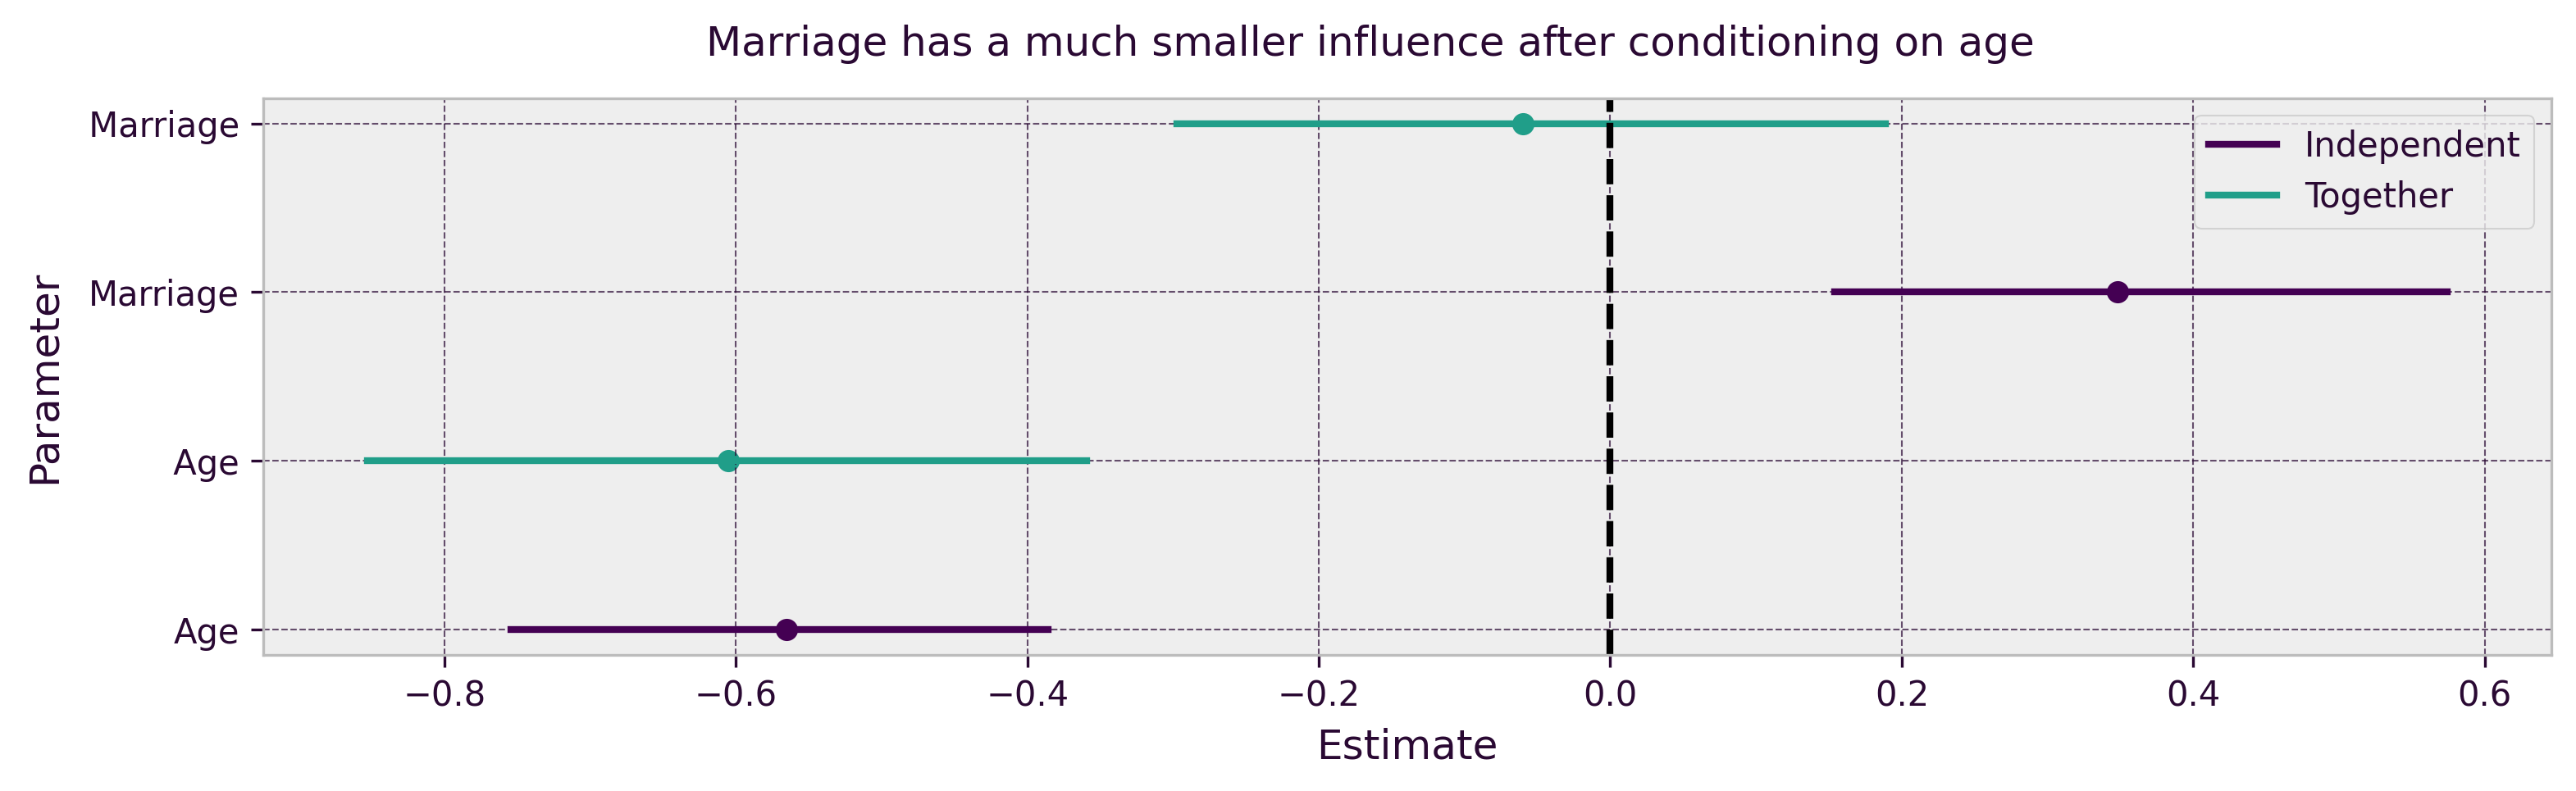

In [12]:
fig, ax = plt.subplots(figsize = (12,3))
x = fit_a.extract('beta')['beta']
r = utils.hpdi(x, .11)
ax.scatter(np.mean(np.mean(x)), "Age", color = '#440053')
ax.plot(r, ['Age', 'Age'], color = "#440053", label = "Independent")

x = fit_5_3.extract('beta[2]')['beta[2]']
r = utils.hpdi(x, .11)
ax.scatter(np.mean(x), " Age", color = '#209E89')
ax.plot(r, [' Age', ' Age'], color = "#209E89", label = "Together")

x = fit_m.extract('beta')['beta']
r = utils.hpdi(x, .11)
ax.scatter(np.mean(x), "Marriage", color = '#440053')
ax.plot(r, ['Marriage', 'Marriage'], color = "#440053")

x = fit_5_3.extract('beta[3]')['beta[3]']
r = utils.hpdi(x, .11)
ax.scatter(np.mean(x), " Marriage", color = '#209E89')
ax.plot(r, [' Marriage', ' Marriage'], color = "#209E89")
ax.axvline(0, linestyle = "--", color = "black", linewidth=2)
ax.set_xlabel("Estimate")
ax.set_ylabel("Parameter")
ax.legend()
fig.suptitle("Marriage has a much smaller influence after conditioning on age")
plt.show()

This graph shows that there is conditional indepence afoot. After conditioning on age of marriage, there is no relationship between marriage age and divorce rate. This would imply the second dag below is the correct one.

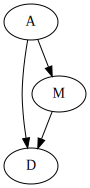

In [13]:
from graphviz import Digraph
# Create Digraph object
dot = Digraph()
# Add nodes 1 and 2
dot.node('A')
dot.node('D')
dot.node('M')
dot.edges(['AD'])
dot.edges(['MD'])
dot.edges(['AM'])
# Visualize the graph
dot

The correct dag is below. D is independent of M after conditioning on A.

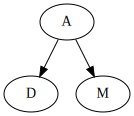

In [14]:
dot = Digraph()
dot.node('A')
dot.node('D')
dot.node('M')
dot.edges(['AD'])
dot.edges(['AM'])
dot

Predictor residual plots help us understand our models. Making **Figure 5.4** is going to take a whole lot of code so buckle in. It will take us through to **Python code 5.14**

In [15]:
x = utils.standardize(d['MedianAgeMarriage'].values)
y = utils.standardize(d['Marriage'].values)
d_dict = {
    "N": X.shape[0],
    "x": x,
    "y": y,
    "prior_only": 0,
    "new_N": 1000,
    "new_x": np.linspace(min(x), max(x), 1000)}
fit_5_4_1 = m_5_1.sampling(d_dict)
print(fit_5_4_1.stansummary(pars=["beta", "sigma"], 
                          probs = [.05, .95]))

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Inference for Stan model: m_5_1_4502a2845a6abcdee1eaadb623e0ad8d.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd     5%    95%  n_eff   Rhat
beta   -0.69  1.6e-3    0.1  -0.85  -0.53   3744    1.0
sigma   0.72  1.2e-3   0.07   0.61   0.85   3695    1.0

Samples were drawn using NUTS at Sat 18 Apr 2020 03:25:02 PM .
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


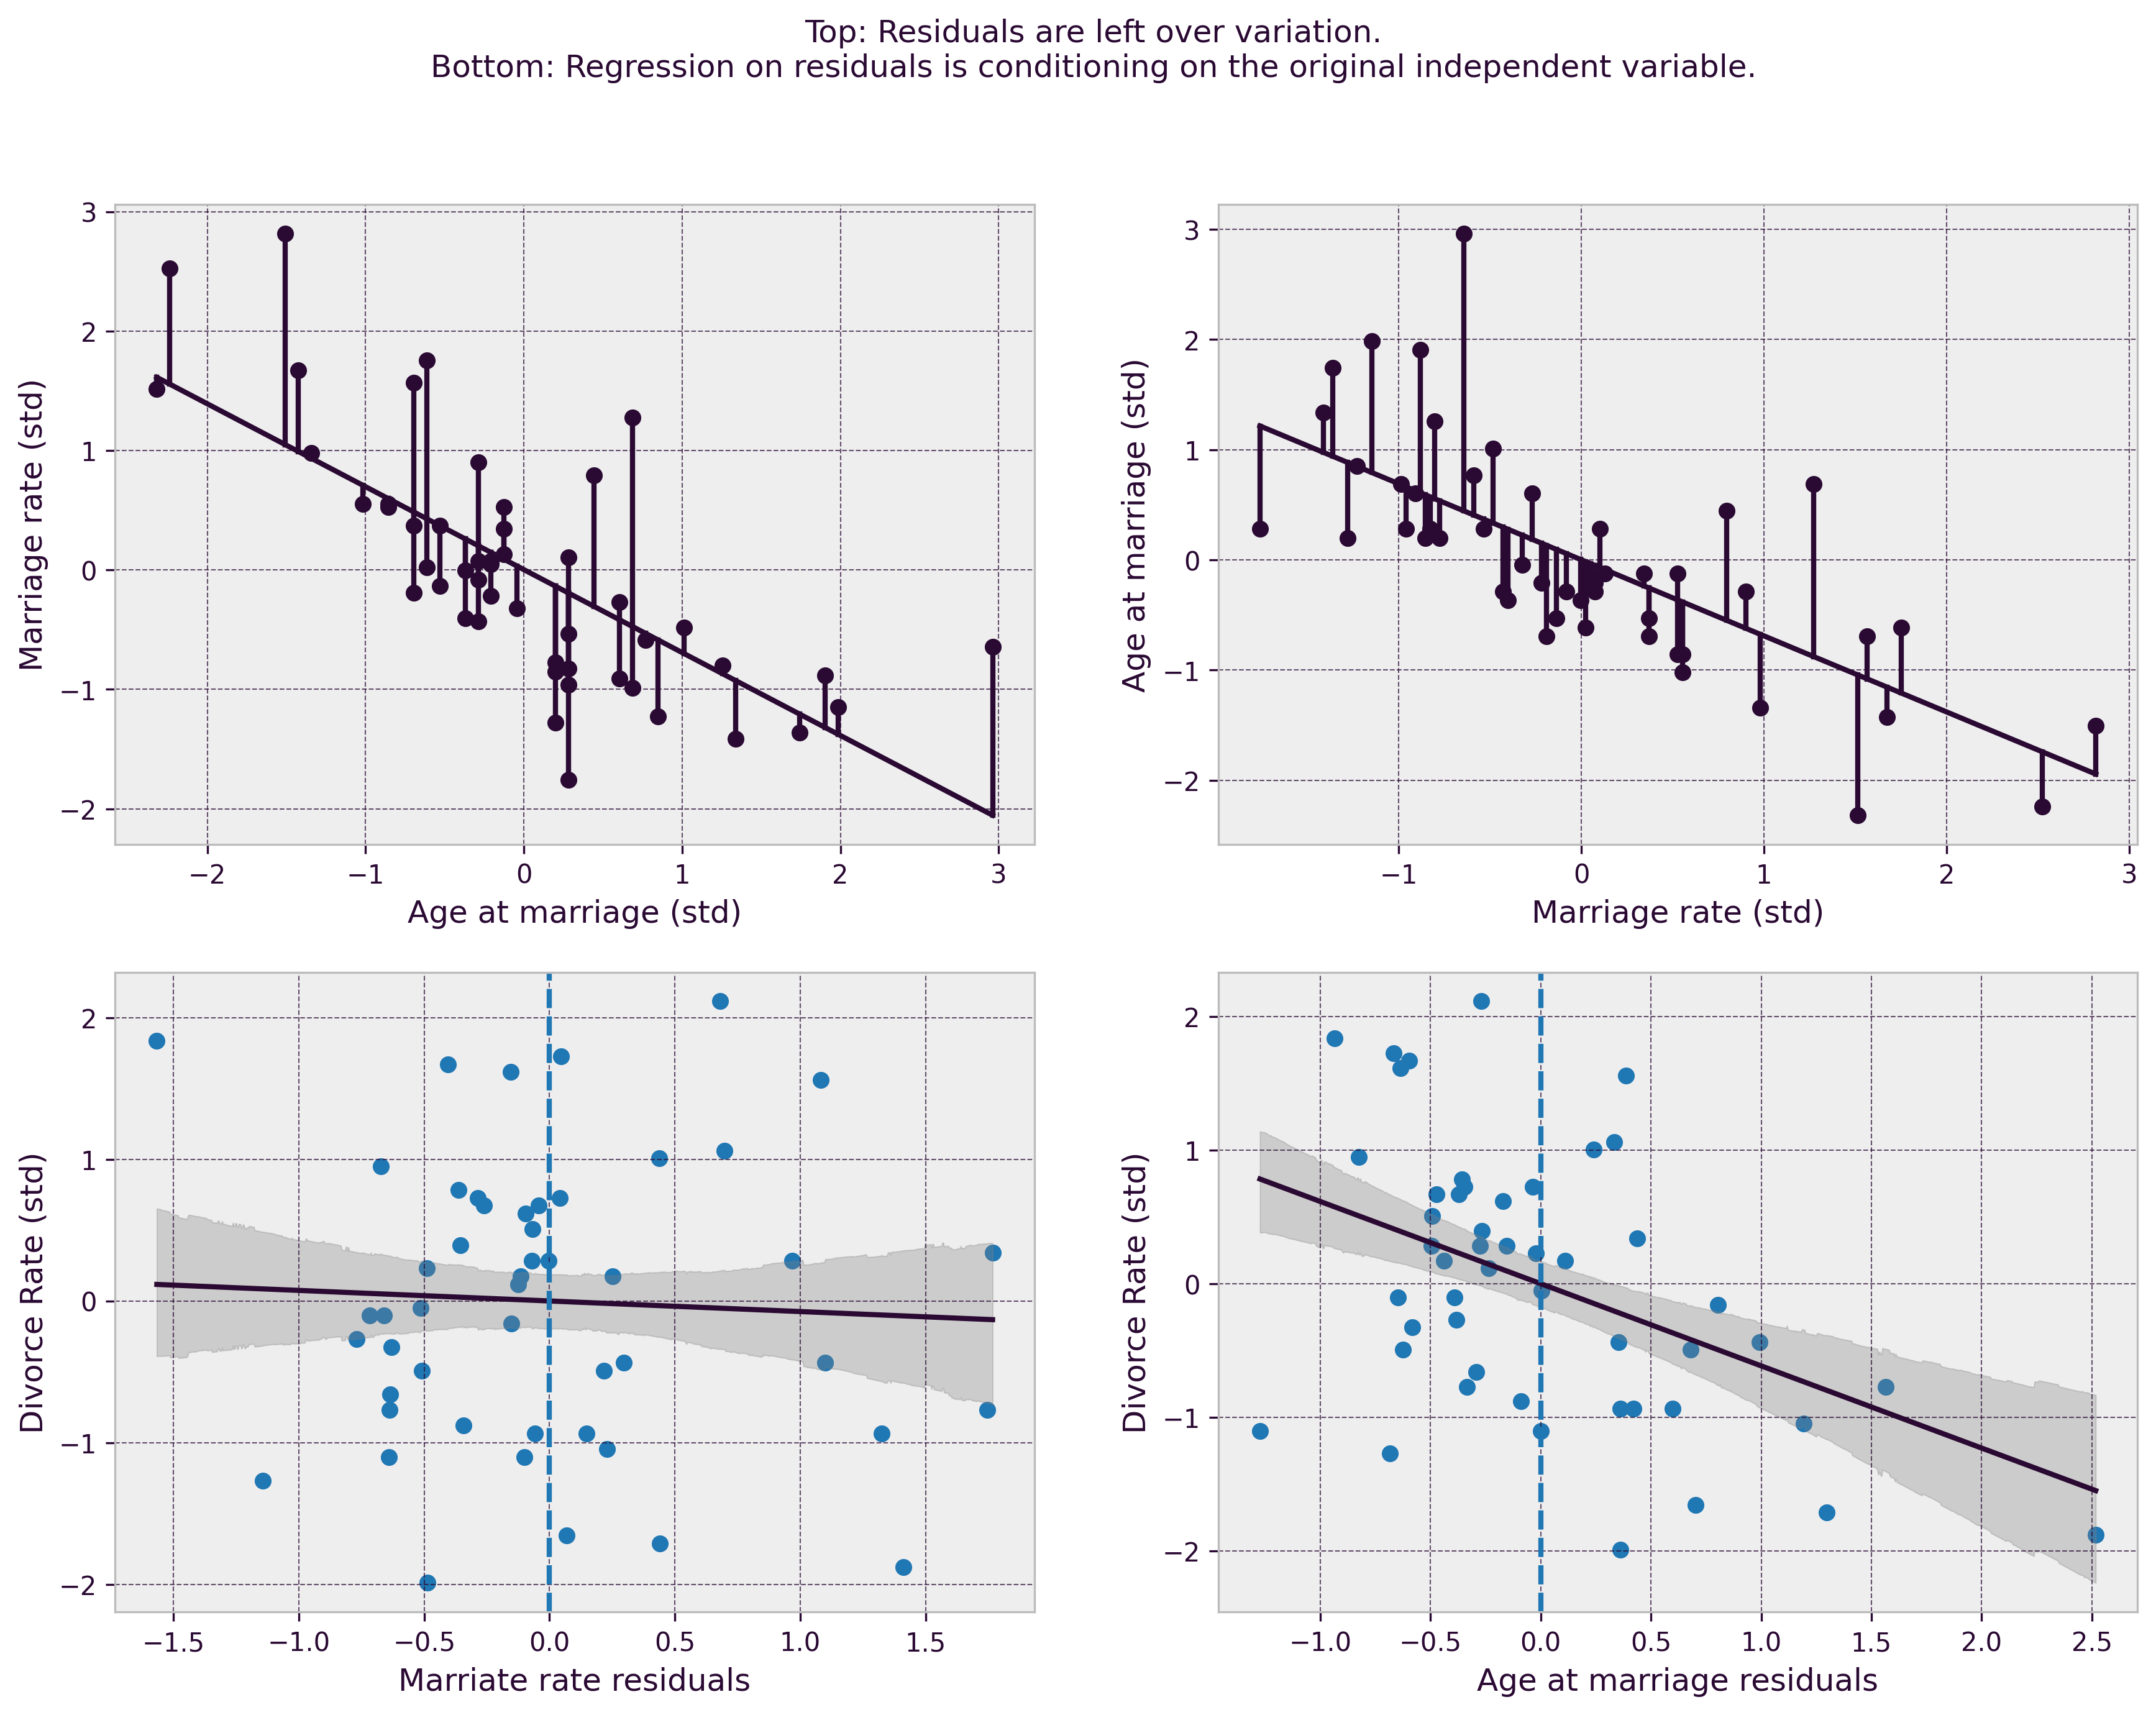

In [16]:
fig, ax = plt.subplots(figsize = (14, 10), nrows = 2, ncols = 2)
x = utils.standardize(d['MedianAgeMarriage'].values)
y = utils.standardize(d['Marriage'].values)
d_dict = {
    "N": len(x),
    "x": x,
    "y": y,
    "prior_only": 0,
    "new_N": 1000,
    "new_x": np.linspace(min(x), max(x), 1000)}
fit_5_4_1 = m_5_1.sampling(d_dict)
post = fit_5_4_1.extract()
mu_mean = np.array([np.mean(m) for m in np.transpose(post['muhat'])])
mu_resid = y - mu_mean
mu_pred = np.array([np.mean(m) for m in np.transpose(post['mupred'])])

ax[0, 0].scatter(x, y, color = COLOR)
ax[0, 0].plot(np.linspace(min(x), max(x), 1000), mu_pred, color = COLOR)
ax[0, 0].plot([x, x], [y, y-mu_resid], color = COLOR)
ax[0, 0].set_xlabel("Age at marriage (std)")
ax[0, 0].set_ylabel("Marriage rate (std)")

x = mu_resid
y = utils.standardize(d['Divorce'].values)
d_dict = {
    "N": len(x),
    "x": x,
    "y": y,
    "prior_only": 0,
    "new_N": 1000,
    "new_x": np.linspace(min(x), max(x), 1000)}
fit_5_4_2 = m_5_1.sampling(d_dict)
post = fit_5_4_2.extract()
y_mu = np.array([np.mean(m) for m in np.transpose(post['mupred'])])
y_mu_shade = np.array([utils.hpdi(m, .11) for m in np.transpose(post['mupred'])])
xseq = np.linspace(min(x), max(x), 1000)

ax[1, 0].scatter(x, y)
ax[1, 0].plot(xseq, y_mu, color=COLOR)
ax[1, 0].fill_between(xseq, y_mu_shade[:,0], y_mu_shade[:,1],
                      color = "grey", alpha = .3)
ax[1, 0].axvline(0, linestyle="--")
ax[1, 0].set_xlabel("Marriate rate residuals")
ax[1, 0].set_ylabel("Divorce Rate (std)")

x = utils.standardize(d['Marriage'].values)
y = utils.standardize(d['MedianAgeMarriage'].values)
d_dict = {
    "N": len(x),
    "x": x,
    "y": y,
    "prior_only": 0,
    "new_N": 1000,
    "new_x": np.linspace(min(x), max(x), 1000)}
fit_5_4_3 = m_5_1.sampling(d_dict)
post = fit_5_4_3.extract()
mu_mean = np.array([np.mean(m) for m in np.transpose(post['muhat'])])
mu_resid = y - mu_mean
mu_pred = np.array([np.mean(m) for m in np.transpose(post['mupred'])])

ax[0, 1].scatter(x, y, color = COLOR)
ax[0, 1].plot(np.linspace(min(x), max(x), 1000), mu_pred, color = COLOR)
ax[0, 1].plot([x, x], [y, y-mu_resid], color = COLOR)
ax[0, 1].set_xlabel("Marriage rate (std)")
ax[0, 1].set_ylabel("Age at marriage (std)")

x = mu_resid
y = utils.standardize(d['Divorce'].values)
d_dict = {
    "N": len(x),
    "x": x,
    "y": y,
    "prior_only": 0,
    "new_N": 1000,
    "new_x": np.linspace(min(x), max(x), 1000)}
fit_5_4_4 = m_5_1.sampling(d_dict)
post = fit_5_4_4.extract()
y_mu = np.array([np.mean(m) for m in np.transpose(post['mupred'])])
y_mu_shade = np.array([utils.hpdi(m, .11) for m in np.transpose(post['mupred'])])

xseq = np.linspace(min(x), max(x), 1000)
ax[1, 1].scatter(x, y)
ax[1, 1].plot(xseq, y_mu, color=COLOR)
ax[1, 1].fill_between(xseq, y_mu_shade[:,0], y_mu_shade[:,1],
                    color = "grey", alpha = .3)
ax[1, 1].axvline(0, linestyle="--")
ax[1, 1].set_xlabel("Age at marriage residuals")
ax[1, 1].set_ylabel("Divorce Rate (std)")
fig.suptitle("Top: Residuals are left over variation.\nBottom: Regression on residuals is conditioning on the original independent variable.")

plt.show()   
             

These plots show that regression measures the remaining association of each predictor with theoutcome, after already knowing the other predictors.

**Python Code 5.15 - 5.17 and Figure 5.5**

Now lets look at posterior prediction plots which comare actuals vs predicted. We'll use the multivarite model we trained for this.

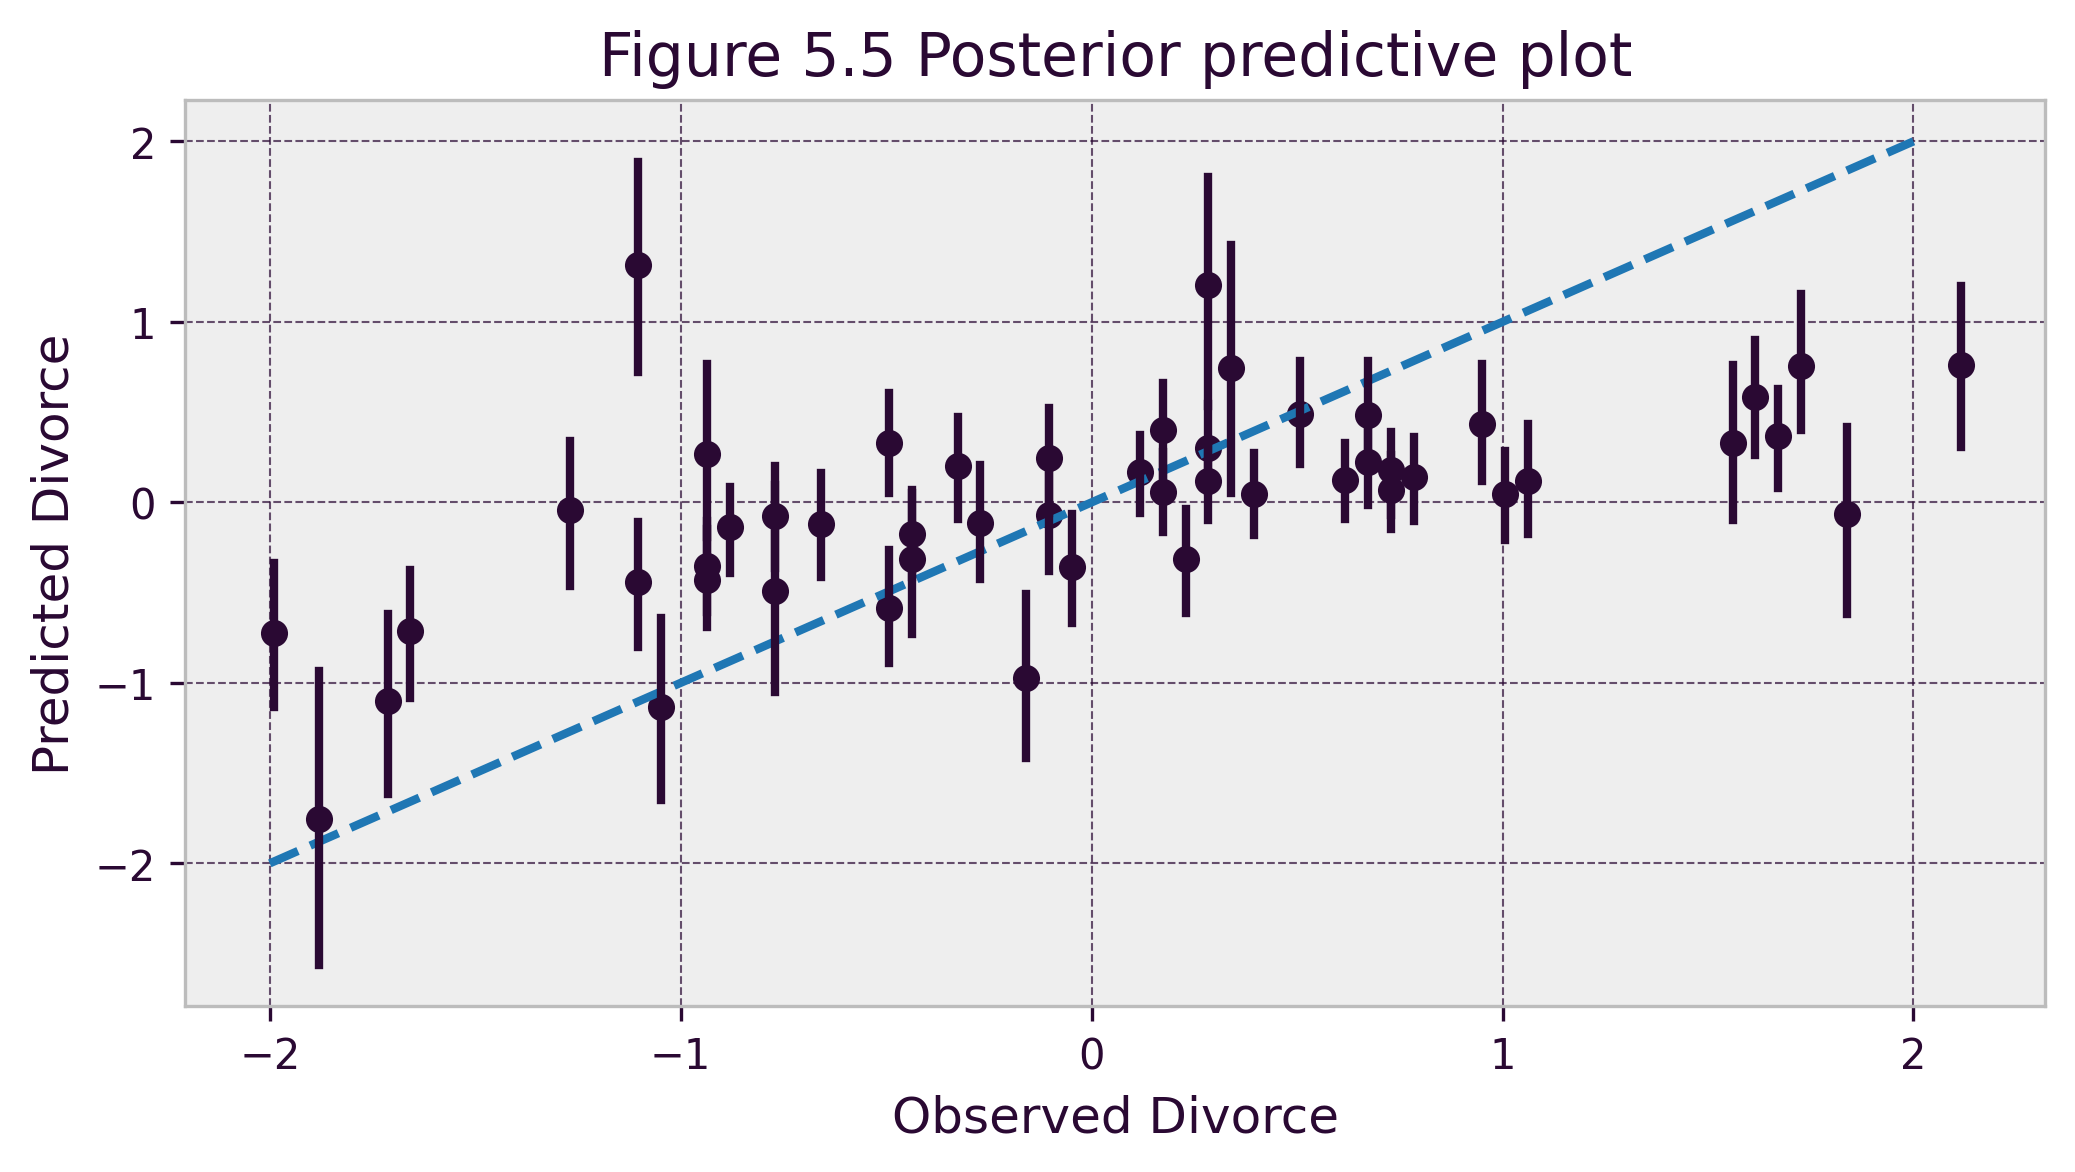

In [17]:
post = fit_5_3.extract()
mu_mean = np.array([np.mean(m) for m in np.transpose(post['muhat'])])
mu_shade = np.array([utils.hpdi(m) for m in np.transpose(post['muhat'])])

fig, ax = plt.subplots(figsize=(8, 4))
xx = utils.standardize(d["Divorce"])
ax.scatter(xx, mu_mean, color = COLOR)
ident = [-2, 2]
ax.plot(ident,ident, linestyle='--')
plt.plot([xx, xx], [mu_shade[:,0], mu_shade[:, 1]], color = COLOR)
ax.set_xlabel("Observed Divorce")
ax.set_ylabel("Predicted Divorce")
ax.set_title("Figure 5.5 Posterior predictive plot")
plt.show()

Counterfactual prediction plots give you predictions for hypothetical combinations of data.

1. Pick a variable to manipulate, the intervention variable.
2. Define the range of values to set the intervention variable to.
3. For each value of the intervention variable, and for each sample in the posterior, use the causal model to simulate the values of other variables, including the outcome.

First we are going to simulate A then propagate it through the dag. This means first simulating A->M, then simulating A->D<-M. We can do this with two separate models but I want to show off how you can just run two models at the same time in stan.

**Python code 5.19 to 5.24 and Figure 5.6 and Figure 5.7**

In [18]:
%%stan m5_3_a
data {
  int N;
  vector[N] divorce;
  vector[N] marriage;
  vector[N] age;
}
parameters {
  // A->D<-M
  real a_amd;
  real b_m_amd;
  real b_a_amd;
  real<lower=0> sigma_amd;
  // A->M
  real a_am;
  real b_a_am;
  real<lower=0> sigma_am;
  // M->D
  real a_md;
  real b_m_md;
  real<lower=0> sigma_md;
}
model {
  // A -> D <- M
  a_amd ~ normal(0, .2);
  b_m_amd ~ normal(0, .5);
  b_a_amd ~ normal(0, .5);
  sigma_amd ~ exponential(1);
  divorce ~ normal(a_amd + b_m_amd*marriage + b_a_amd*age, sigma_amd);
  // A -> M
  a_am ~ normal(0, .2);
  b_a_am ~ normal(0, .5);
  sigma_am ~ exponential(1);
  marriage ~ normal(a_am + b_a_am*age, sigma_am);
}

INFO:pystan:COMPILING THE C++ CODE FOR MODEL m5_3_a_3cbe9bf930b4b98200f8380efd9d3612 NOW.


Creating pystan model & assigning it to variable name "m5_3_a".
Stan options:
 {'model_name': 'm5_3_a', 'include_paths': None, 'boost_lib': None, 'eigen_lib': None, 'verbose': False, 'obfuscate_model_name': True}
StanModel now available as variable "m5_3_a"!
Compilation took 38 seconds.


In [19]:
df = (d[['MedianAgeMarriage', 'Marriage', 'Divorce']]
      .apply(utils.standardize))

d_dict = {"N": len(df.index),
 "divorce": df['Divorce'].values,
 "age": df['MedianAgeMarriage'].values,
 "marriage": df['Marriage']}

fit_5_3_a = m5_3_a.sampling(d_dict)
print(fit_5_3_a.stansummary(probs=[.05, .95]))

Inference for Stan model: m5_3_a_3cbe9bf930b4b98200f8380efd9d3612.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean     sd      5%     95%  n_eff   Rhat
a_amd      5.1e-3  4.7e-3    0.1   -0.16    0.16    440   1.01
b_m_amd     -0.06  8.0e-3   0.15   -0.29    0.18    340   1.02
b_a_amd     -0.61  8.4e-3   0.15   -0.87   -0.35    327   1.02
sigma_amd    0.83  4.2e-3   0.09     0.7    0.98    440   1.01
a_am      -5.6e-3  4.3e-3   0.09   -0.16    0.14    450   1.01
b_a_am      -0.69  5.8e-3    0.1   -0.86   -0.52    314   1.01
sigma_am     0.72  3.8e-3   0.08    0.61    0.86    423    1.0
a_md       467.49  910.07 4586.7   -7802  7903.0     25   1.19
b_m_md     -1.1e4   2.2e4  3.4e4  -7.3e4   3.6e4      2   3.23
sigma_md      inf     nan    inf 7.7e306 1.7e308    nan    nan
lp__       680.88     0.1   2.14  676.91  683.82    444   1.01

Samples were drawn using NUTS at Sat 18 Apr 2020 03:25:47 

/home/rishi/.local/share/virtualenvs/rethinking2-DossOK6r/lib/python3.6/site-packages/numpy/core/_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/home/rishi/.local/share/virtualenvs/rethinking2-DossOK6r/lib/python3.6/site-packages/numpy/core/_methods.py:183: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True)


First we simulate A. Then we simulate M using A_sim and the relationship we learned between A->M in our posterior. Then we use the simulated A and simulated M to predict D using out posterior again.

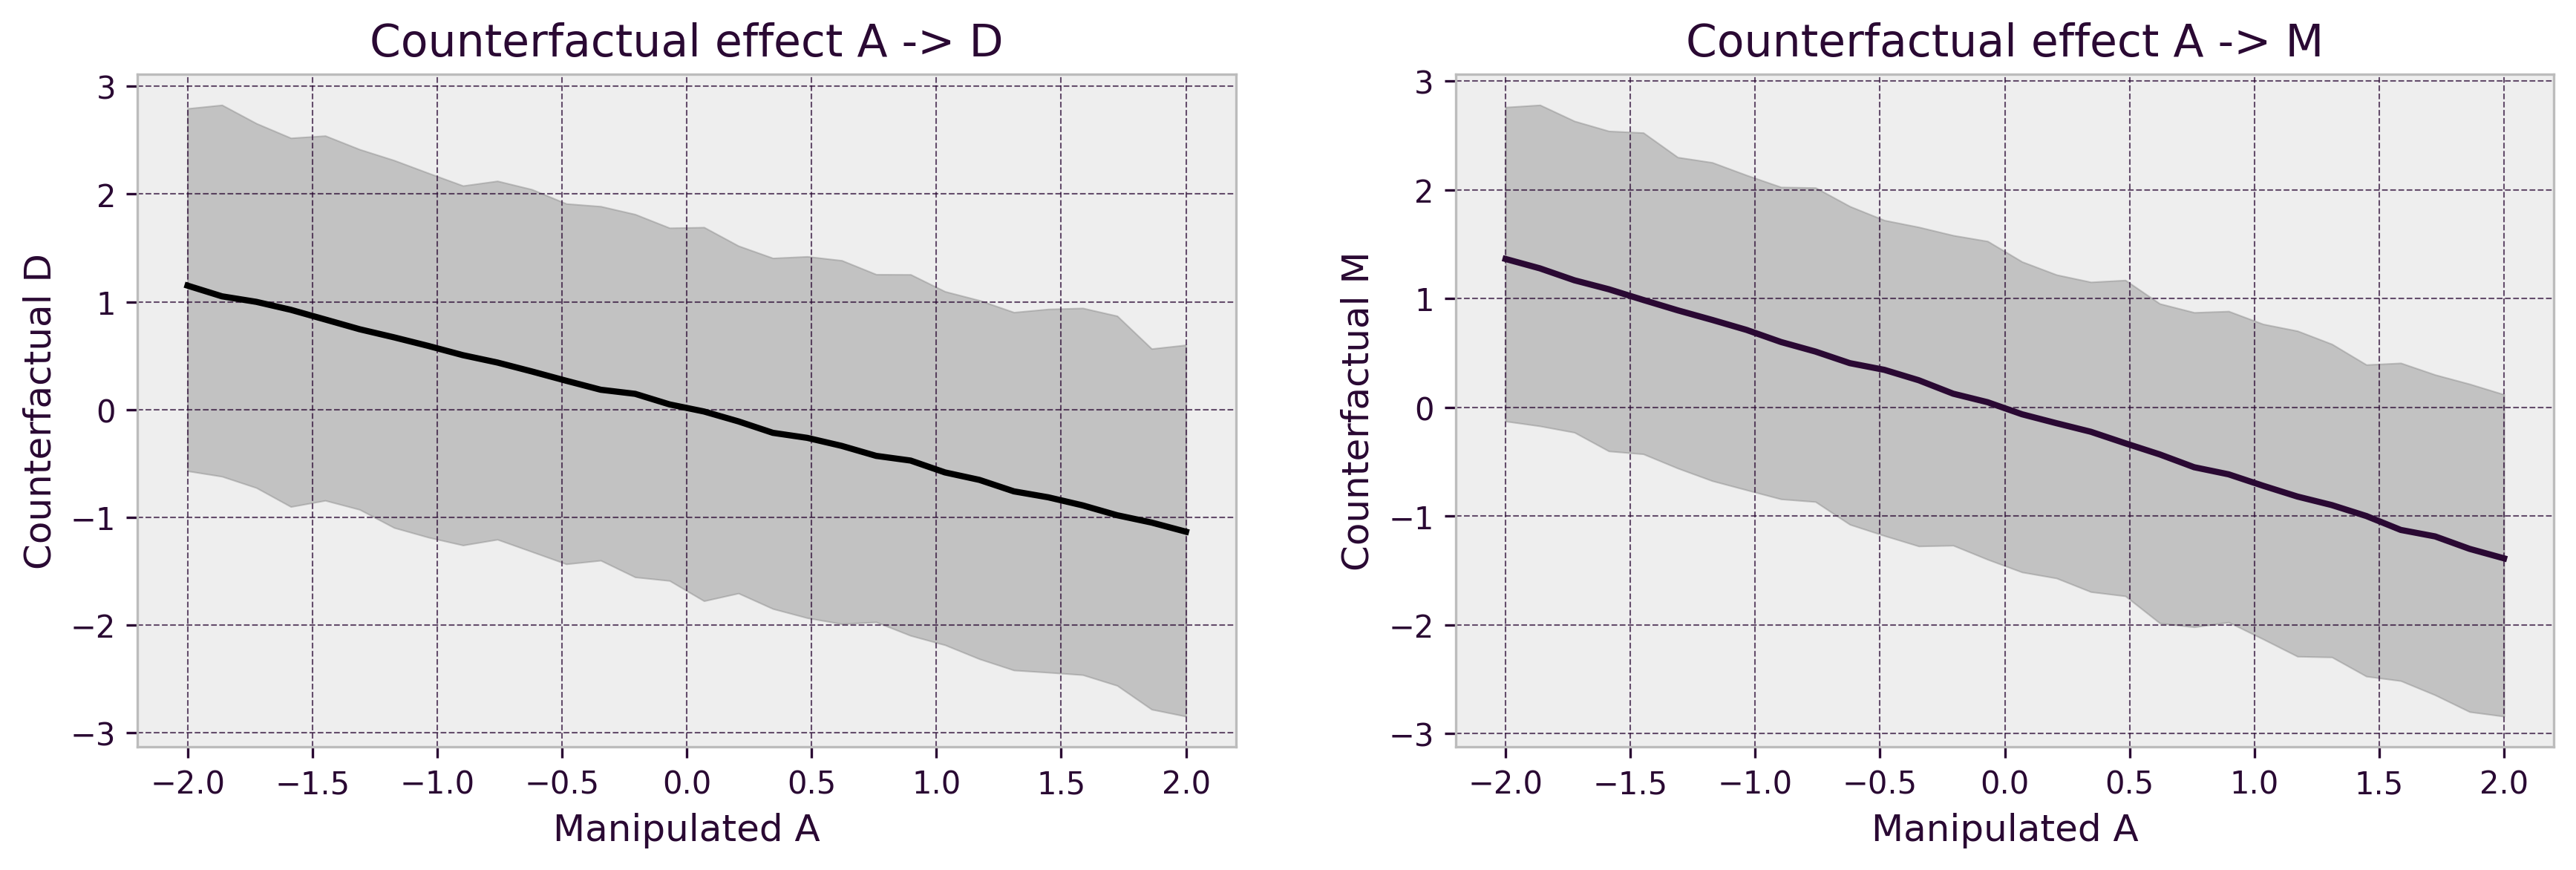

In [20]:
# Simulate some ages
A_seq = np.linspace(-2, 2, 30)
post = fit_5_3_a.extract()
# Simulate posterior marriage for each age
M_sim = np.array([stats.norm.rvs(
    loc = post['a_am'] + post['b_a_am']*v,
    scale = post['sigma_am']) for v in A_seq])
# Simulate divorce based on marriage_sim and age_sim
D_sim = np.array([stats.norm.rvs(
    loc = post['a_amd'] + post['b_a_amd']*A_seq[i] + post['b_m_amd']*M_sim[i,:],
    scale = post['sigma_amd']) for i in range(30)])
# Plot results
fig, ax = plt.subplots(figsize=(14,4), ncols=2)
mu = np.apply_along_axis(np.mean,1, D_sim)
mu_shade = np.apply_along_axis(utils.hpdi,1, D_sim)
ax[0].plot(
    A_seq, mu,    
    color ="black")
ax[0].fill_between(A_seq, mu_shade[:,0], mu_shade[:,1],
                color = "grey", alpha =.4)
ax[0].set_xlabel("Manipulated A")
ax[0].set_ylabel("Counterfactual D")
ax[0].set_title("Counterfactual effect A -> D")

mu = np.apply_along_axis(np.mean,1, M_sim)
mu_shade = np.apply_along_axis(utils.hpdi,1, M_sim)
ax[1].plot(
    A_seq, mu,
    color =COLOR)
ax[1].fill_between(A_seq, mu_shade[:,0], mu_shade[:,1],
                color = "grey", alpha =.4)
ax[1].set_xlabel("Manipulated A")
ax[1].set_ylabel("Counterfactual M")
ax[1].set_title("Counterfactual effect A -> M")

plt.show()

We can see that after conditioning on A, there is not much of an effect for M->D. To run this counterfactual we're going to set Age to 0. Because we centered and scaled our variables, that just means setting it to 0.

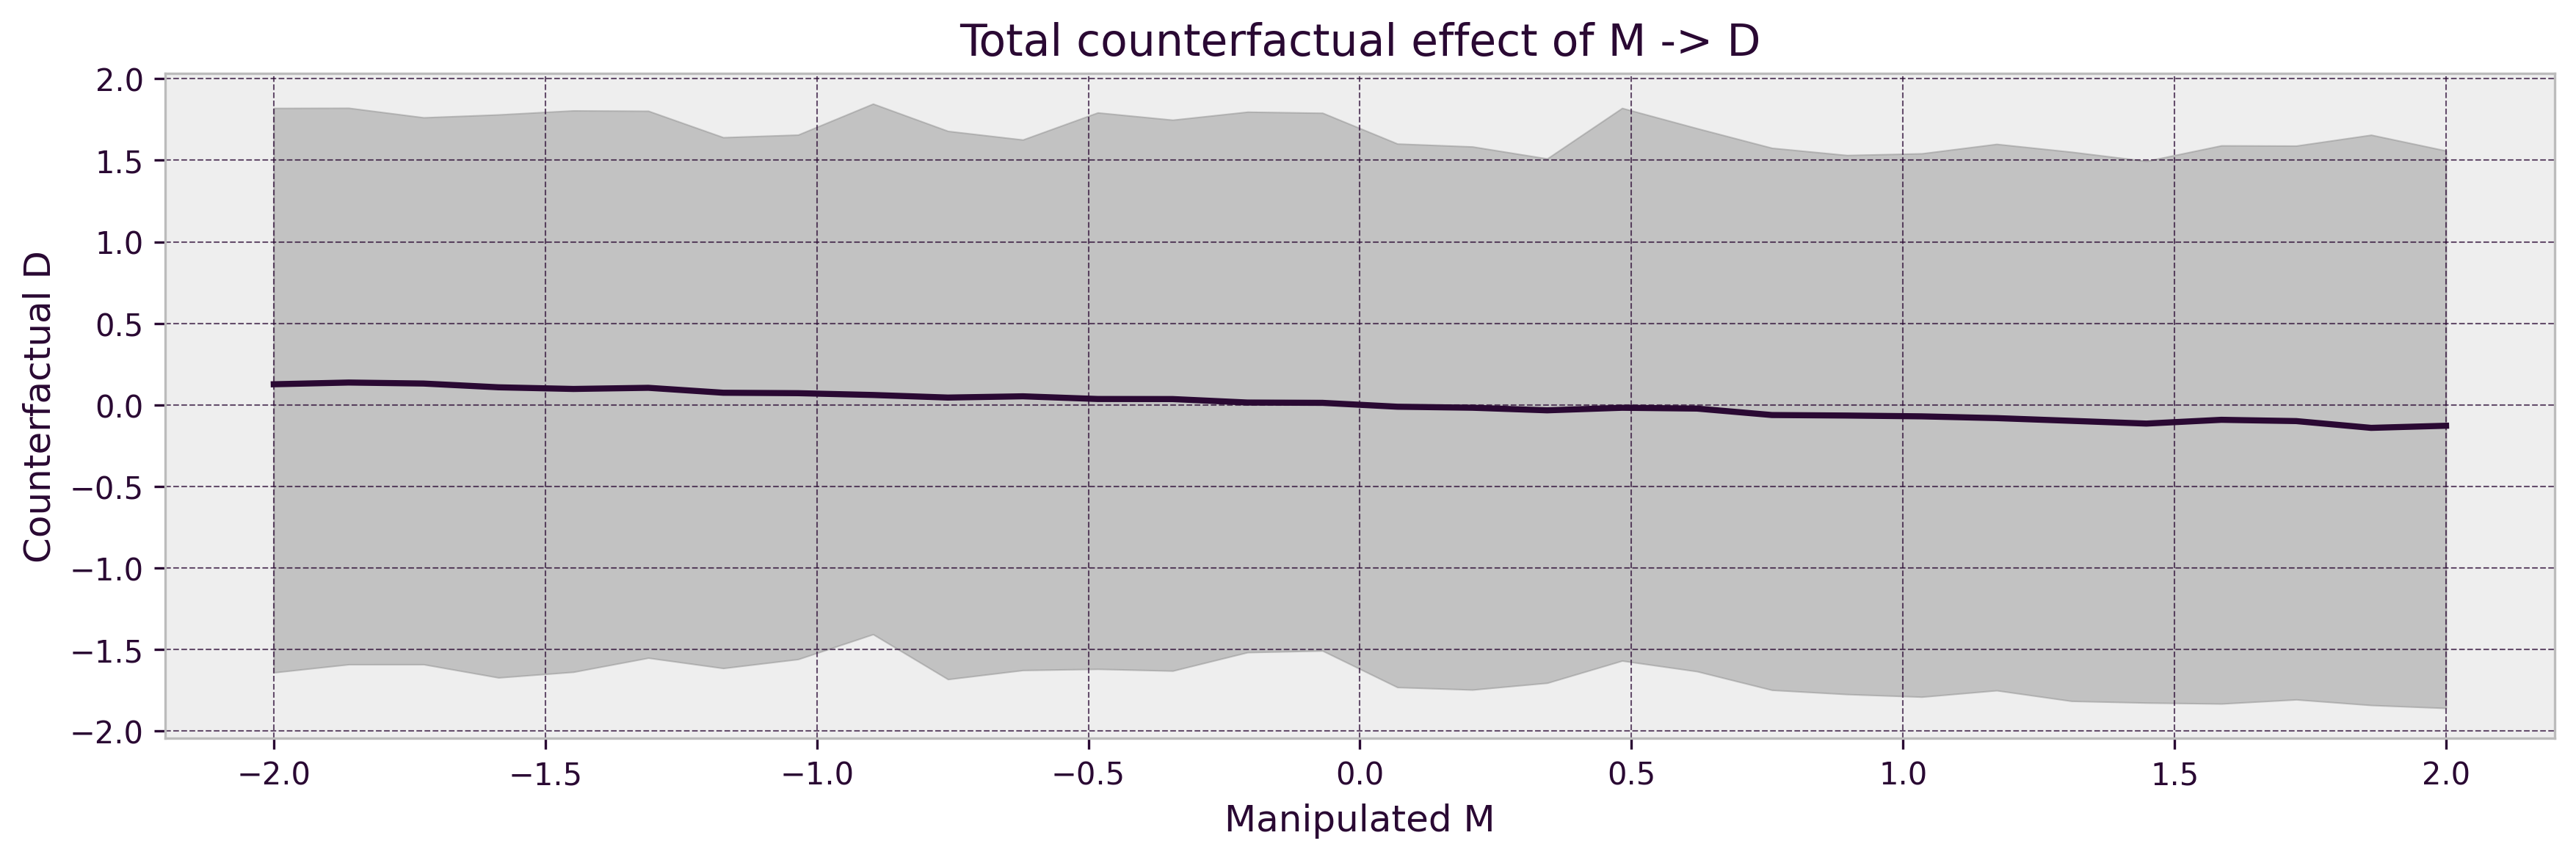

In [21]:
M_seq = np.linspace(-2, 2, 30)
D_sim = np.array([stats.norm.rvs(
    loc = post['a_amd'] + post['b_a_amd']*0 + post['b_m_amd']*v,
    scale = post['sigma_amd']) for v in M_seq])

fig, ax = plt.subplots(figsize=(14,4))
mu = np.apply_along_axis(np.mean,1, D_sim)
mu_shade = np.apply_along_axis(utils.hpdi,1, D_sim)
ax.plot(M_seq, mu, color=COLOR)
ax.fill_between(M_seq, mu_shade[:,0], mu_shade[:, 1],
               color = "grey", alpha=.4)
ax.set_xlabel("Manipulated M")
ax.set_ylabel("Counterfactual D")
ax.set_title("Total counterfactual effect of M -> D")
plt.show()

So... Lets summarize this section. In the following dag, `A -> D <- M <- A`, the relationship `M->D` is _spurious_. We know this because our posterior inference tells us that $D \perp \!\!\! \perp M | A$.

# 5.2 - Masked Relationship

Masked relationships occur when two different variables affect the outcome in different directions. We use a dataset of primate species to examine this. We think `neo -> kcal <- mass`. Just like before, we'll fit two bivariate relationships then train a multivariate regression.

**Python code 5.28 - 5.34 and Figure 5.8**

In [22]:
d = utils.data_from_R("milk", "rethinking")
df = (d
 .loc[:, ['kcal.per.g', 'neocortex.perc', 'mass']]
 .rename(columns={"kcal.per.g": "kcal", "neocortex.perc": "neo"})
 .assign(mass = lambda x: np.log(x.mass))
 .apply(utils.standardize)
 .dropna())
df.describe()

kcal           neo       mass
count  17.000000  1.700000e+01  17.000000
mean    0.100400 -2.873518e-15   0.034451
std     1.090197  1.030776e+00   1.158550
min    -1.145842 -2.144217e+00  -2.134963
25%    -0.956680 -5.242954e-01  -0.601501
50%    -0.136979  2.200395e-01   0.129697
75%     0.997991  6.362454e-01   1.233474
max     2.069908  1.506651e+00   1.757934

First we check out the bivariate relationship between neocortex and kcal. We begin with a prior predictive check. We'll try two sets of priors out and pick the best looking one.

In [23]:
%%stan m5_5
data{
  int N;
  vector[N] x;
  vector[N] y;
  real prior_alpha[2];
  real prior_beta[2];
  int prior_only;
}
parameters {
  real alpha;
  real beta1;
  real<lower=0> sigma;
}
model {
  alpha ~ normal(prior_alpha[1], prior_alpha[2]);
  beta1 ~ normal(prior_beta[1], prior_beta[2]);
  sigma ~ exponential(1);
  if (!prior_only) {
    y ~ normal(alpha + beta1*x, sigma);
  }
}

INFO:pystan:COMPILING THE C++ CODE FOR MODEL m5_5_04426ae901c7057e8d4fef4c3454a2e9 NOW.


Creating pystan model & assigning it to variable name "m5_5".
Stan options:
 {'model_name': 'm5_5', 'include_paths': None, 'boost_lib': None, 'eigen_lib': None, 'verbose': False, 'obfuscate_model_name': True}
StanModel now available as variable "m5_5"!
Compilation took 38 seconds.


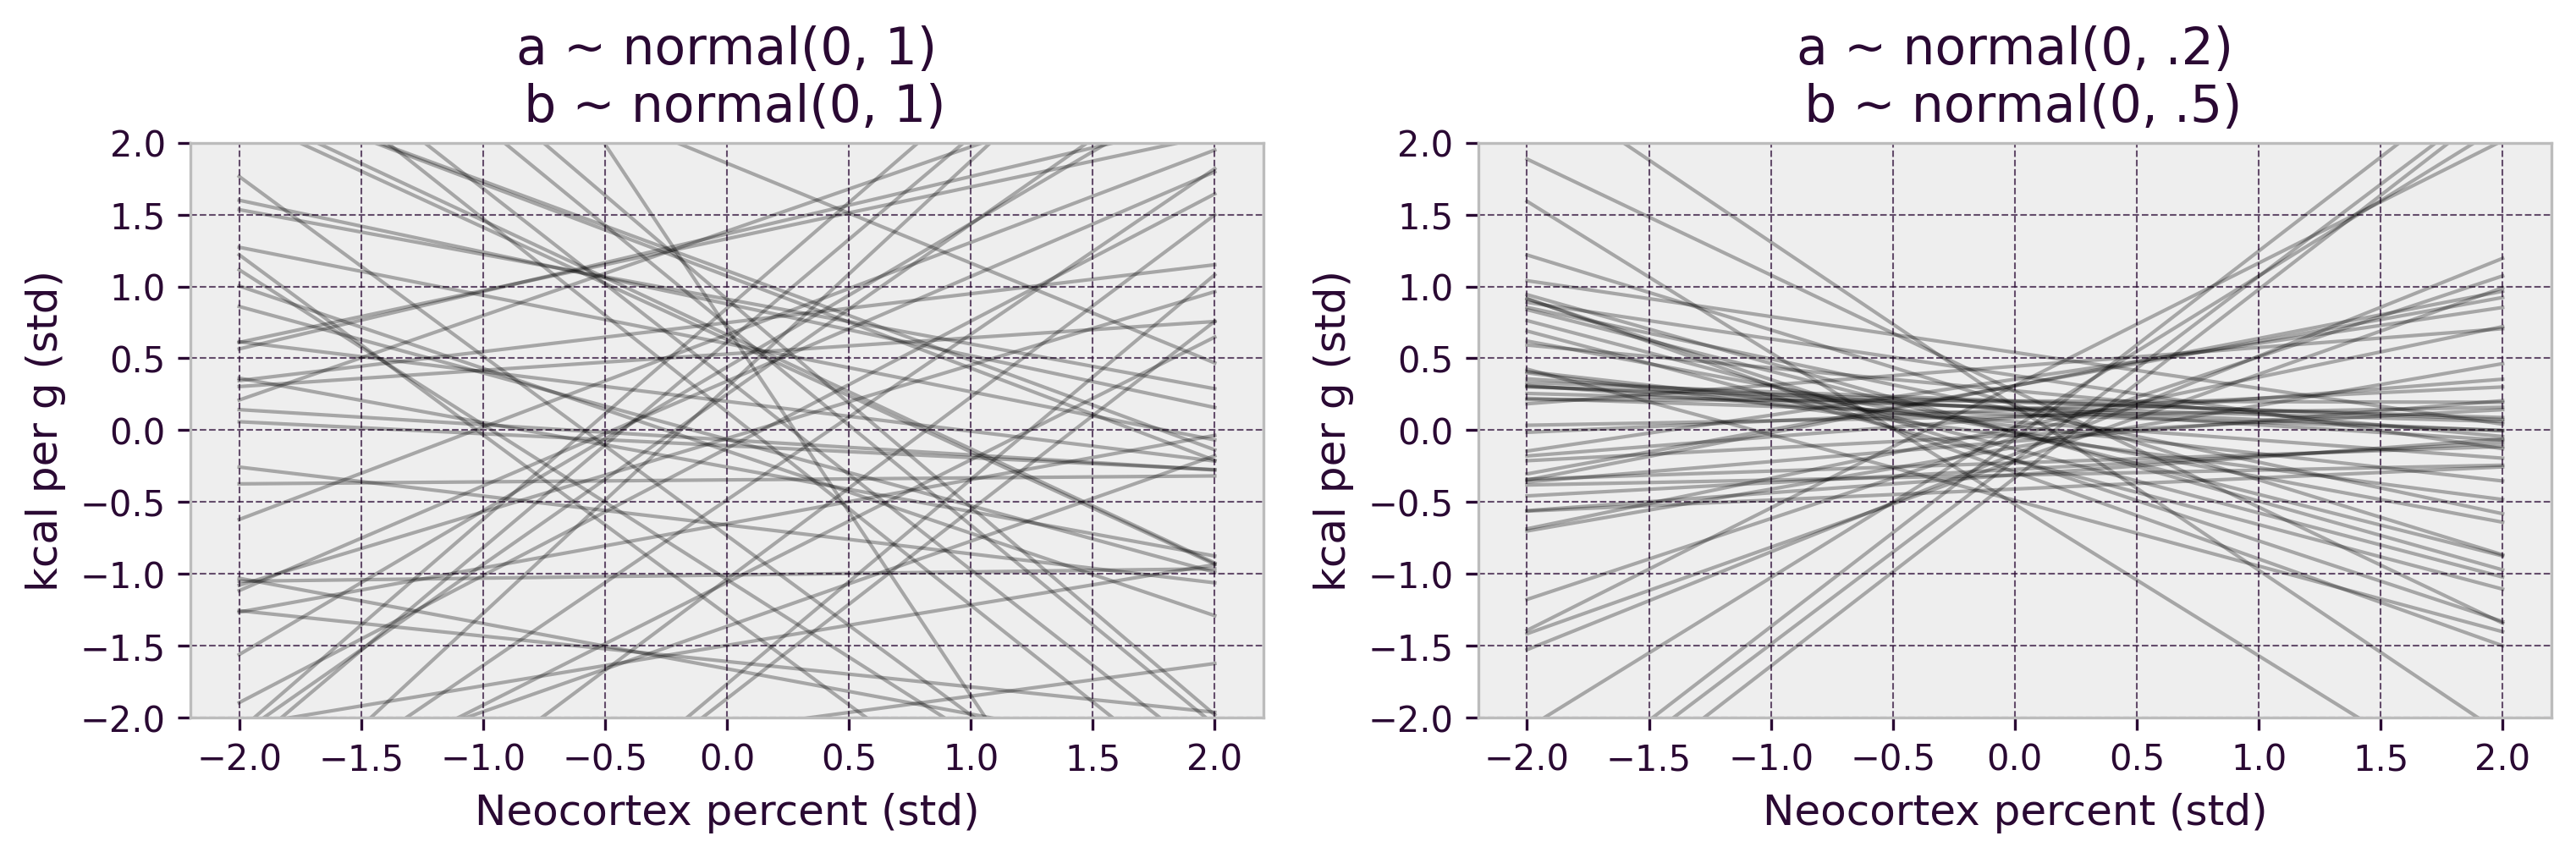

In [24]:
d_dict = {
    "N": len(df.index),
    "x": df.neo.values,
    "y": df.kcal.values,
    "prior_alpha": [0, 1],
    "prior_beta": [0 ,1],
    "prior_only": 1}
fit_m5_5_weak = m5_5.sampling(d_dict)
d_dict['prior_alpha'] = [0, .2]
d_dict['prior_beta'] = [0, .5]
fit_m5_5_strong = m5_5.sampling(d_dict)
post_weak = fit_m5_5_weak.extract()
post_strong = fit_m5_5_strong.extract()

fig, axes = plt.subplots(figsize=(12, 3), ncols=2)
xseq = np.linspace(-2, 2, 100)
for i in range(50):
    axes[0].plot(xseq, post_weak['alpha'][i] + post_weak['beta1'][i]*xseq, 
                 color = "black", alpha=.3, linewidth=1)
    axes[1].plot(xseq, post_strong['alpha'][i] + post_strong['beta1'][i]*xseq, 
                 color = "black", alpha=.3, linewidth=1)
axes[0].set_ylim([-2, 2])
axes[0].set_xlabel("Neocortex percent (std)")
axes[0].set_ylabel("kcal per g (std)")
axes[0].set_title("a ~ normal(0, 1)\n b ~ normal(0, 1)")
axes[1].set_ylim([-2, 2])
axes[1].set_xlabel("Neocortex percent (std)")
axes[1].set_ylabel("kcal per g (std)")
axes[1].set_title("a ~ normal(0, .2)\n b ~ normal(0, .5)")
plt.show()

The second option looks better, so lets go with that and find the posterior.

**Python code 5.35 - 5.40**

In [25]:
d_dict['prior_only'] = 0
fit_m5_5 = m5_5.sampling(d_dict)
print(fit_m5_5.stansummary(probs=[.05, .95]))

Inference for Stan model: m5_5_04426ae901c7057e8d4fef4c3454a2e9.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd     5%    95%  n_eff   Rhat
alpha   0.03  2.5e-3   0.15  -0.22   0.28   3571    1.0
beta1   0.13  3.9e-3   0.23  -0.26    0.5   3634    1.0
sigma   1.13  3.8e-3    0.2   0.84   1.49   2815    1.0
lp__   -11.8    0.03   1.18 -14.16 -10.51   1906    1.0

Samples were drawn using NUTS at Sat 18 Apr 2020 03:26:28 PM .
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


Now lets also fit a model for `mass->kcal`.

In [26]:
d_dict['x'] = df['mass'].values
fit_m5_6 = m5_5.sampling(d_dict)
print(fit_m5_6.stansummary(probs=[.05, .95]))

Inference for Stan model: m5_5_04426ae901c7057e8d4fef4c3454a2e9.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd     5%    95%  n_eff   Rhat
alpha   0.04  2.6e-3   0.15  -0.22   0.29   3635    1.0
beta1  -0.27  4.0e-3   0.21  -0.62   0.08   2895    1.0
sigma   1.08  4.1e-3    0.2   0.81   1.46   2461    1.0
lp__   -11.1    0.03   1.27  -13.6  -9.74   1572    1.0

Samples were drawn using NUTS at Sat 18 Apr 2020 03:26:28 PM .
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


And finally, lets train the multivariate model.

In [27]:
%%stan m5_7
data{
  int N;
  int K;
  matrix[N, K] X;
  vector[N] y;
  real prior_alpha[2];
  real prior_beta[2];
  int prior_only;
}
parameters {
  vector[K] betas;
  real<lower=0> sigma;
}
model {
  betas[1] ~ normal(prior_alpha[1], prior_alpha[2]);
  betas[2:K] ~ normal(prior_beta[1], prior_beta[2]);
  sigma ~ exponential(1);
  
  if (!prior_only) {
    y ~ normal(X * betas, sigma);
  }
}

INFO:pystan:COMPILING THE C++ CODE FOR MODEL m5_7_4582cf27edf0b1a3bf5f6675b027505a NOW.


Creating pystan model & assigning it to variable name "m5_7".
Stan options:
 {'model_name': 'm5_7', 'include_paths': None, 'boost_lib': None, 'eigen_lib': None, 'verbose': False, 'obfuscate_model_name': True}
StanModel now available as variable "m5_7"!
Compilation took 39 seconds.


In [28]:
import patsy
X = patsy.dmatrix("1 + neo + mass", data = df)
d_dict = {
    "N": X.shape[0],
    "K": X.shape[1],
    "X": np.array(X),
    "y": df["kcal"].values,
    "prior_alpha": [0, .2],
    "prior_beta": [0, .5],
    "prior_only": 0}
fit_m5_7 = m5_7.sampling(d_dict)
print(fit_m5_7.stansummary(probs=[.05, .95]))

Inference for Stan model: m5_7_4582cf27edf0b1a3bf5f6675b027505a.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd     5%    95%  n_eff   Rhat
betas[1]   0.06  2.4e-3   0.15  -0.18   0.29   3654    1.0
betas[2]   0.61  5.9e-3   0.26   0.16   1.01   2011    1.0
betas[3]  -0.65  5.2e-3   0.24  -1.03  -0.23   2156    1.0
sigma      0.88  3.8e-3   0.18   0.63    1.2   2227    1.0
lp__      -9.05    0.04   1.46 -11.91  -7.34   1703    1.0

Samples were drawn using NUTS at Sat 18 Apr 2020 03:27:08 PM .
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


So how do the bivariate relationships compare to the multivariate? We examine the two slopes below. Personally I like showing the full distribution instead of the plot coeftab spits out.

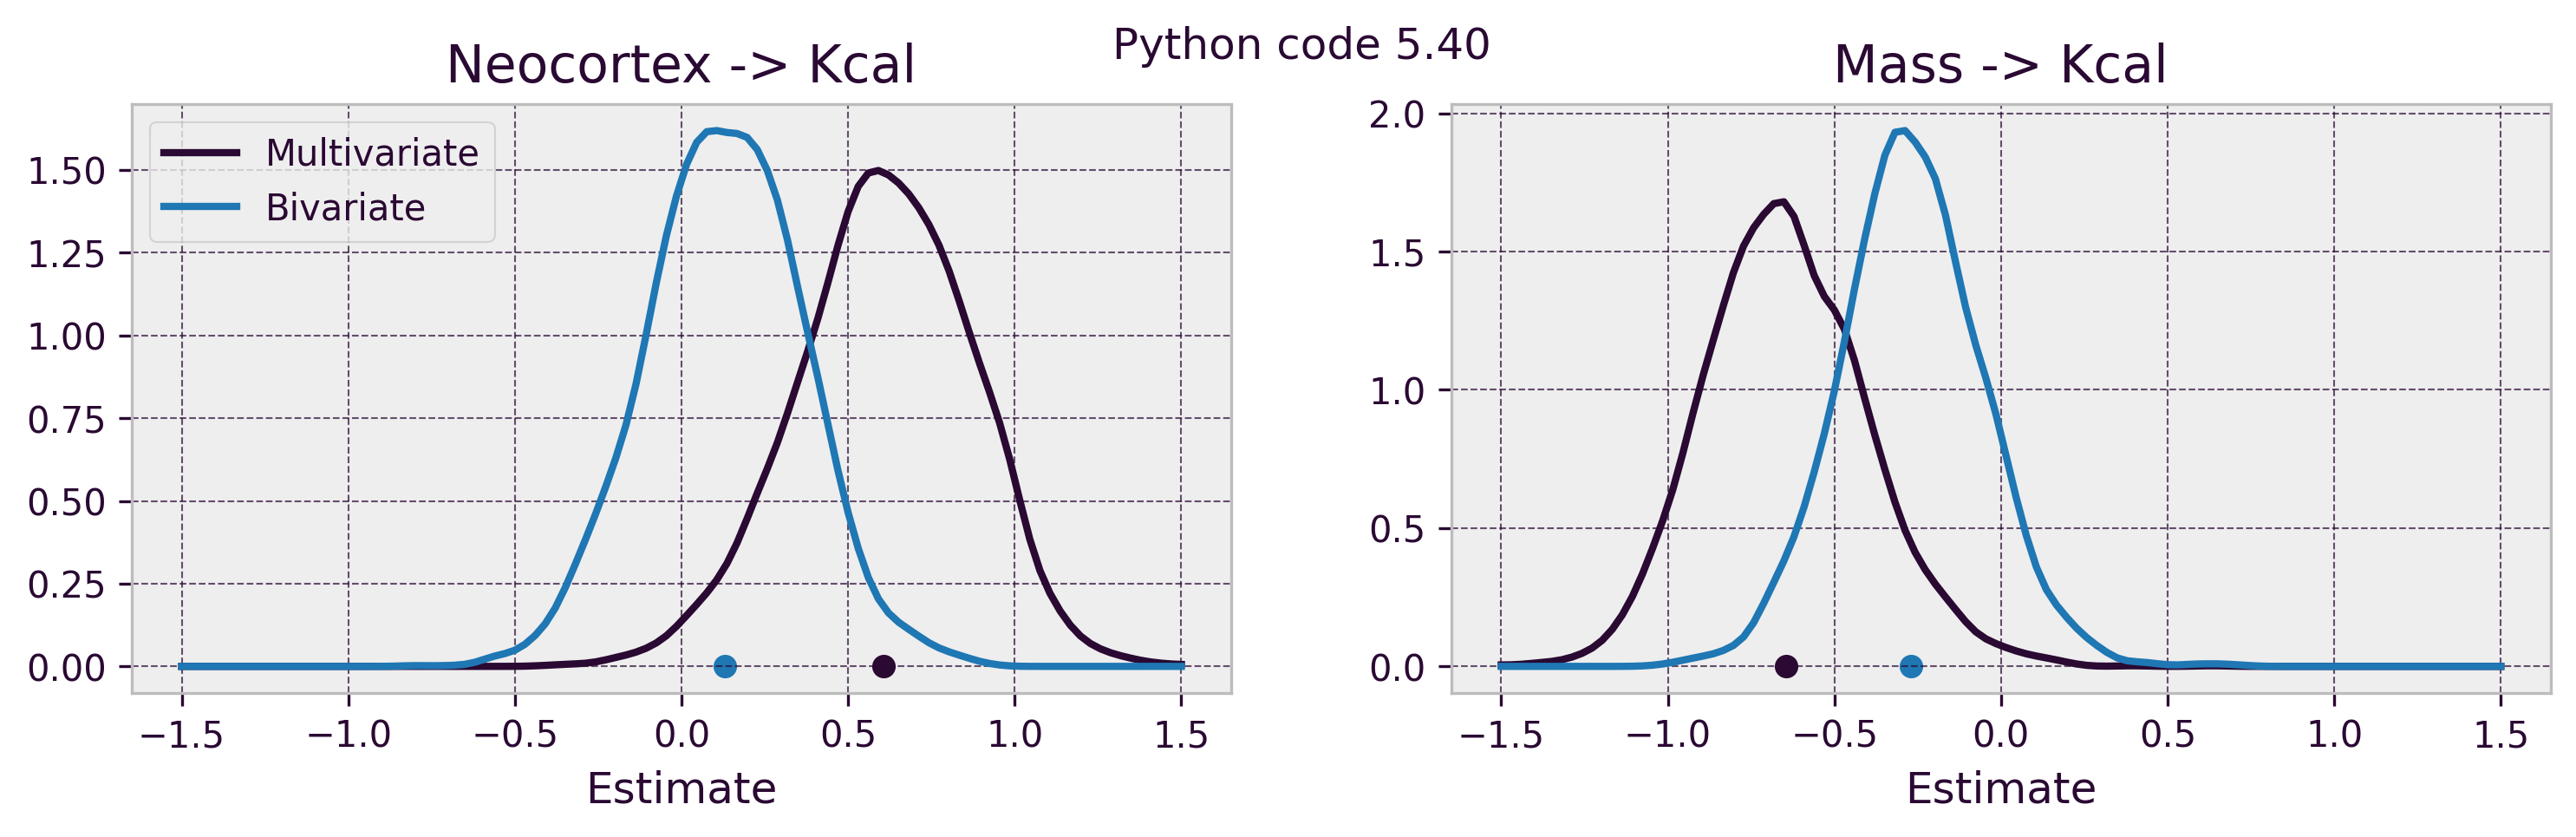

In [29]:
post_m57 = fit_m5_7.extract()
post_m56 = fit_m5_6.extract()
post_m55 = fit_m5_5.extract()


xseq = np.linspace(-1.5, 1.5, 100)
fig, axes = plt.subplots(figsize=(12,3), ncols=2)
axes[0].set_title("Neocortex -> Kcal")
axes[0].set_xlabel("Estimate")
axes[1].set_xlabel("Estimate")
y = utils.plotting.build_dens(post_m57['betas'][:,1], xseq)
axes[0].plot(xseq, y, color = COLOR, label = "Multivariate")
axes[0].scatter(np.mean(post_m57['betas'][:,1]), 0, color = COLOR)
y = utils.plotting.build_dens(post_m55['beta1'], xseq)
axes[0].plot(xseq, y, label = "Bivariate")
axes[0].scatter(np.mean(post_m55['beta1']), 0)
axes[0].legend()
axes[1].set_title("Mass -> Kcal")
y = utils.plotting.build_dens(post_m57['betas'][:,2], xseq)
axes[1].plot(xseq, y, color = COLOR, label="Multivariate")
axes[1].scatter(np.mean(post_m57['betas'][:,2]), 0, color = COLOR)
y = utils.plotting.build_dens(post_m56['beta1'], xseq)
axes[1].plot(xseq, y, label = "Bivariate")
axes[1].scatter(np.mean(post_m56['beta1']), 0)
axes[1].legend
fig.suptitle("Python code 5.40")
plt.show()

Combining both variables in to the regression increased both their magnitude.

Now lets combine it all together to make **figure 5.9**

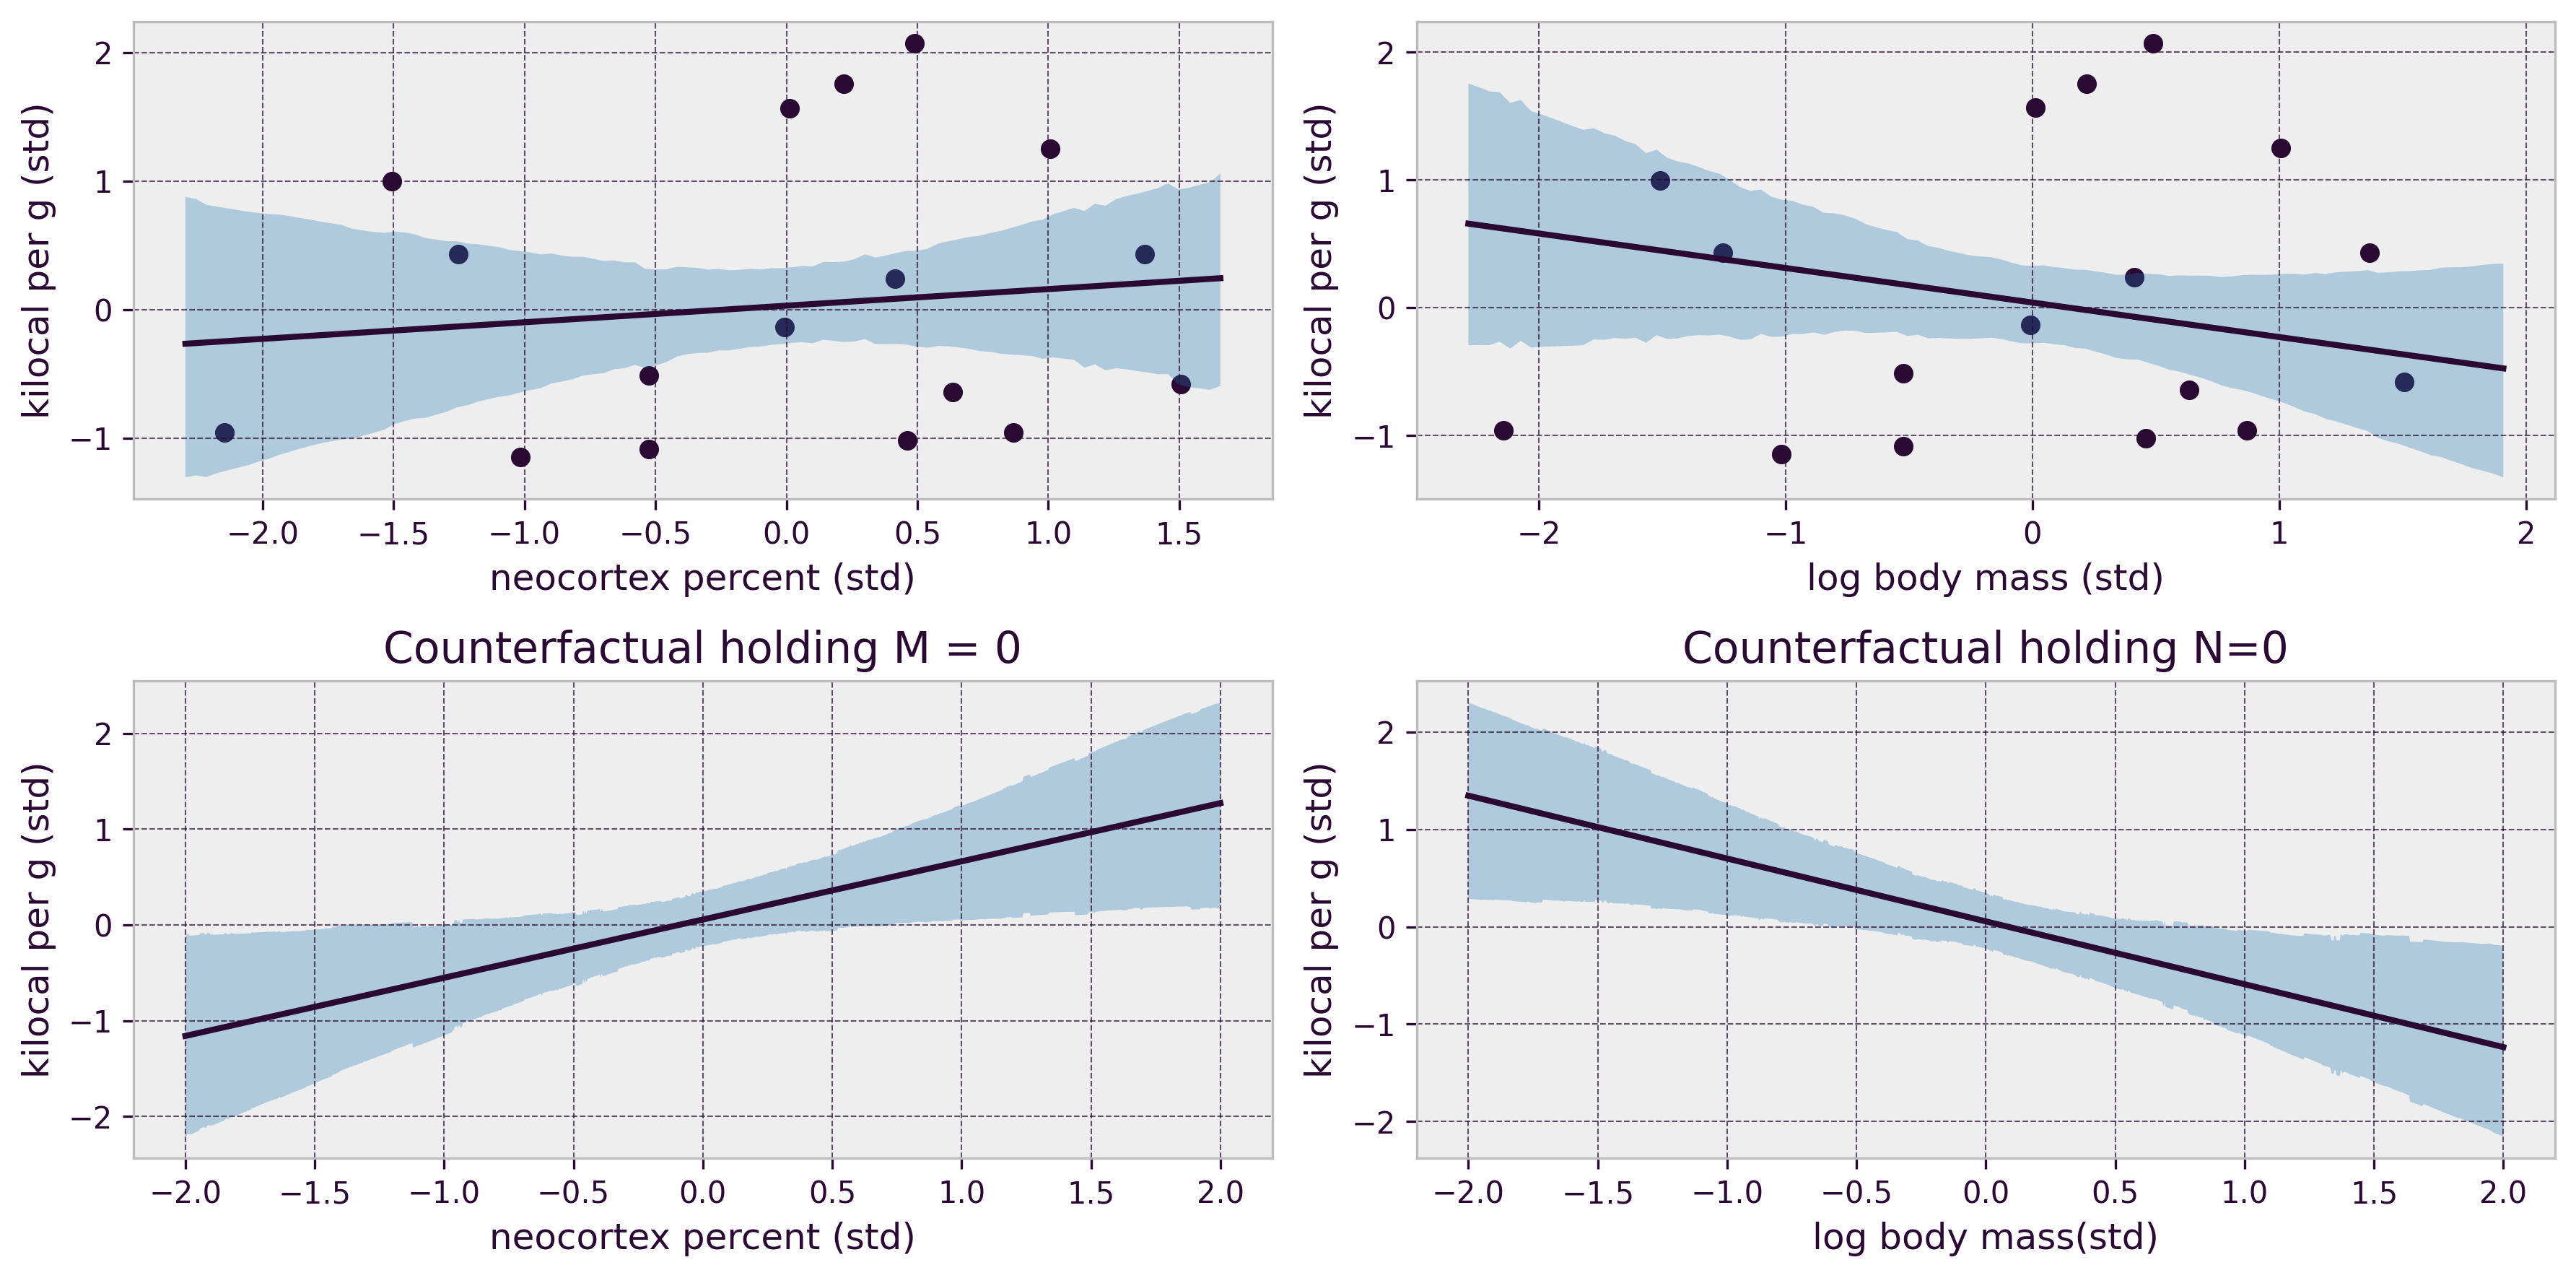

In [30]:
post = fit_m5_5.extract()
xseq = np.linspace(min(df['neo'])-.15, max(df['neo'])+.15, 100)
Beta = np.array([post['alpha'], post['beta1']])
X = np.array([np.ones(100), xseq])
yhat = np.matmul(np.transpose(X), Beta)
ymu = np.apply_along_axis(np.mean,1,yhat)
ymu_shade = np.apply_along_axis(utils.hpdi, 1, yhat)

fig, axes = plt.subplots(figsize=(12,6), ncols=2, nrows = 2)
axes[0, 0].scatter(df['neo'], df['kcal'], color = COLOR)
axes[0, 0].plot(xseq, ymu, color = COLOR)
axes[0, 0].fill_between(xseq, ymu_shade[:,0], ymu_shade[:, 1], alpha = .3)
axes[0, 0].set_xlabel("neocortex percent (std)")
axes[0, 0].set_ylabel("kilocal per g (std)")

post = fit_m5_6.extract()
xseq = np.linspace(min(df['mass'])-.15, max(df['mass'])+.15, 100)
Beta = np.array([post['alpha'], post['beta1']])
X = np.array([np.ones(100), xseq])
yhat = np.matmul(np.transpose(X), Beta)
ymu = np.apply_along_axis(np.mean,1,yhat)
ymu_shade = np.apply_along_axis(utils.hpdi, 1, yhat)

axes[0, 1].scatter(df['neo'], df['kcal'], color = COLOR)
axes[0, 1].plot(xseq, ymu, color = COLOR)
axes[0, 1].fill_between(xseq, ymu_shade[:,0], ymu_shade[:, 1], alpha = .3)
axes[0, 1].set_xlabel("log body mass (std)")
axes[0, 1].set_ylabel("kilocal per g (std)")

post = fit_m5_7.extract()
X = np.array([np.ones(1000),
              np.linspace(-2, 2, 1000),
              np.zeros(1000)])
yhat = np.matmul(np.transpose(X), np.transpose(post['betas']))
ymu = np.apply_along_axis(np.mean,1,yhat)
ymu_shade = np.apply_along_axis(utils.hpdi,1,yhat)
axes[1,0].plot(X[1,:], ymu, color = COLOR)
axes[1,0].fill_between(X[1,:], ymu_shade[:,0], ymu_shade[:,1], alpha = .3)
axes[1,0].set_title("Counterfactual holding M = 0")
axes[1,0].set_xlabel("neocortex percent (std)")
axes[1,0].set_ylabel("kilocal per g (std)")
X = np.array([np.ones(1000),
              np.zeros(1000),
              np.linspace(-2, 2, 1000)])
yhat = np.matmul(np.transpose(X), np.transpose(post['betas']))
ymu = np.apply_along_axis(np.mean,1,yhat)
ymu_shade = np.apply_along_axis(utils.hpdi,1,yhat)
axes[1,1].plot(X[2,:], ymu, color = COLOR)
axes[1,1].fill_between(X[2,:], ymu_shade[:,0], ymu_shade[:,1], alpha = .3)
axes[1,1].set_title("Counterfactual holding N=0")
axes[1,1].set_xlabel("log body mass(std)")
axes[1,1].set_ylabel("kilocal per g (std)")
fig.tight_layout()
plt.show()

Whats going on here? Lets plot pairs of variables. The effects of neo and mass cancel each other out on kcal.

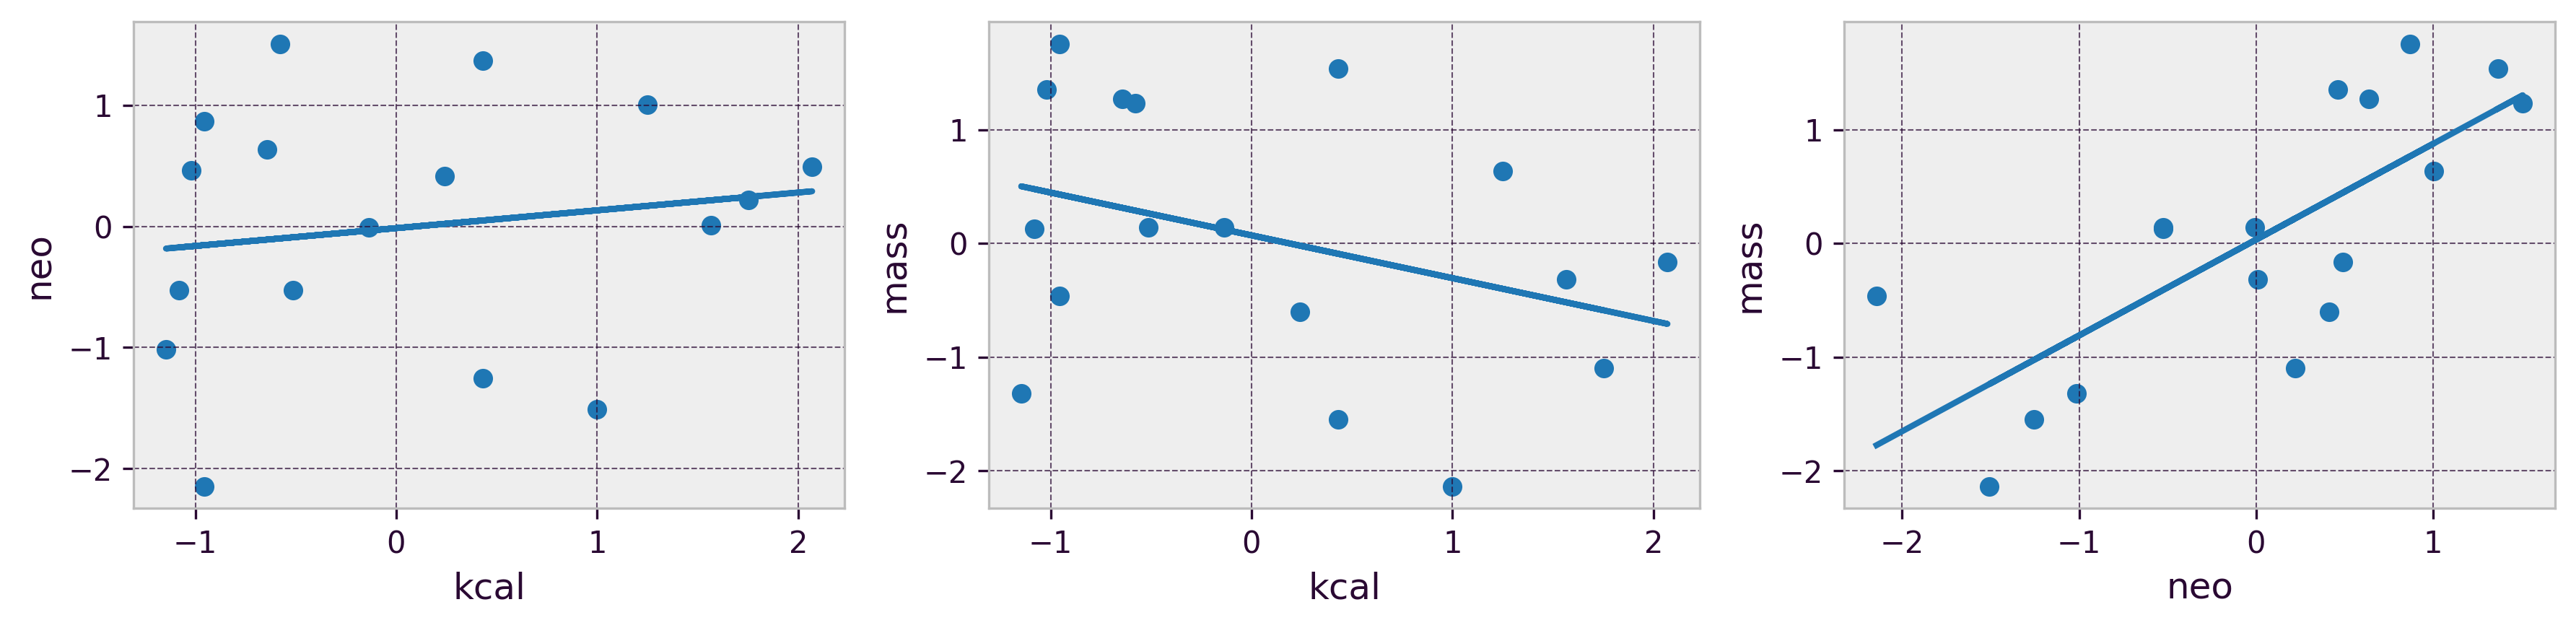

In [49]:
fig, axes = plt.subplots(figsize=(12,3), ncols=3)
axes[0].set_xlabel("kcal")
axes[0].set_ylabel("neo")
axes[0].scatter(df['kcal'], df['neo'])
z = np.polyfit(df['kcal'], df['neo'], 1)
p = np.poly1d(z)
axes[0].plot(df['kcal'],p(df['kcal']))

axes[1].set_xlabel("kcal")
axes[1].set_ylabel("mass")
axes[1].scatter(df['kcal'], df['mass'])
z = np.polyfit(df['kcal'], df['mass'], 1)
p = np.poly1d(z)
axes[1].plot(df['kcal'],p(df['kcal']))

axes[2].set_xlabel("neo")
axes[2].set_ylabel("mass")
axes[2].scatter(df['neo'], df['mass'])
z = np.polyfit(df['neo'], df['mass'], 1)
p = np.poly1d(z)
axes[2].plot(df['neo'],p(df['neo']))
fig.tight_layout()
plt.show()

# 5.3 - Categorical Variables

Not all variables are continuous, some are categories. Lets talk through how to work with those.

**Python code 5.45 - 5.47**

In [50]:
d = utils.data_from_R("Howell1", "rethinking")
d.describe()

height      weight         age        male
count  544.000000  544.000000  544.000000  544.000000
mean   138.263596   35.610618   29.344393    0.472426
std     27.602448   14.719178   20.746888    0.499699
min     53.975000    4.252425    0.000000    0.000000
25%    125.095000   22.007717   12.000000    0.000000
50%    148.590000   40.057844   27.000000    0.000000
75%    157.480000   47.209005   43.000000    1.000000
max    179.070000   62.992589   88.000000    1.000000

We're going to look at the effect of gender on height. Be careful using a dummy variable! It falsely increases the uncertainty of your slope! 

$$
height ~ normal(\mu_i, \sigma)\\
\mu_i = \alpha + \beta*m_i \\
\alpha \sim Normal(178, 30)\\
\beta_m \sim Normal(0, 10)\\
\sigma \sim Uniform(0, 50)
$$

This is because $male = \beta_m$ but $female = \beta_m + \alpha$. Lets simulate this below.


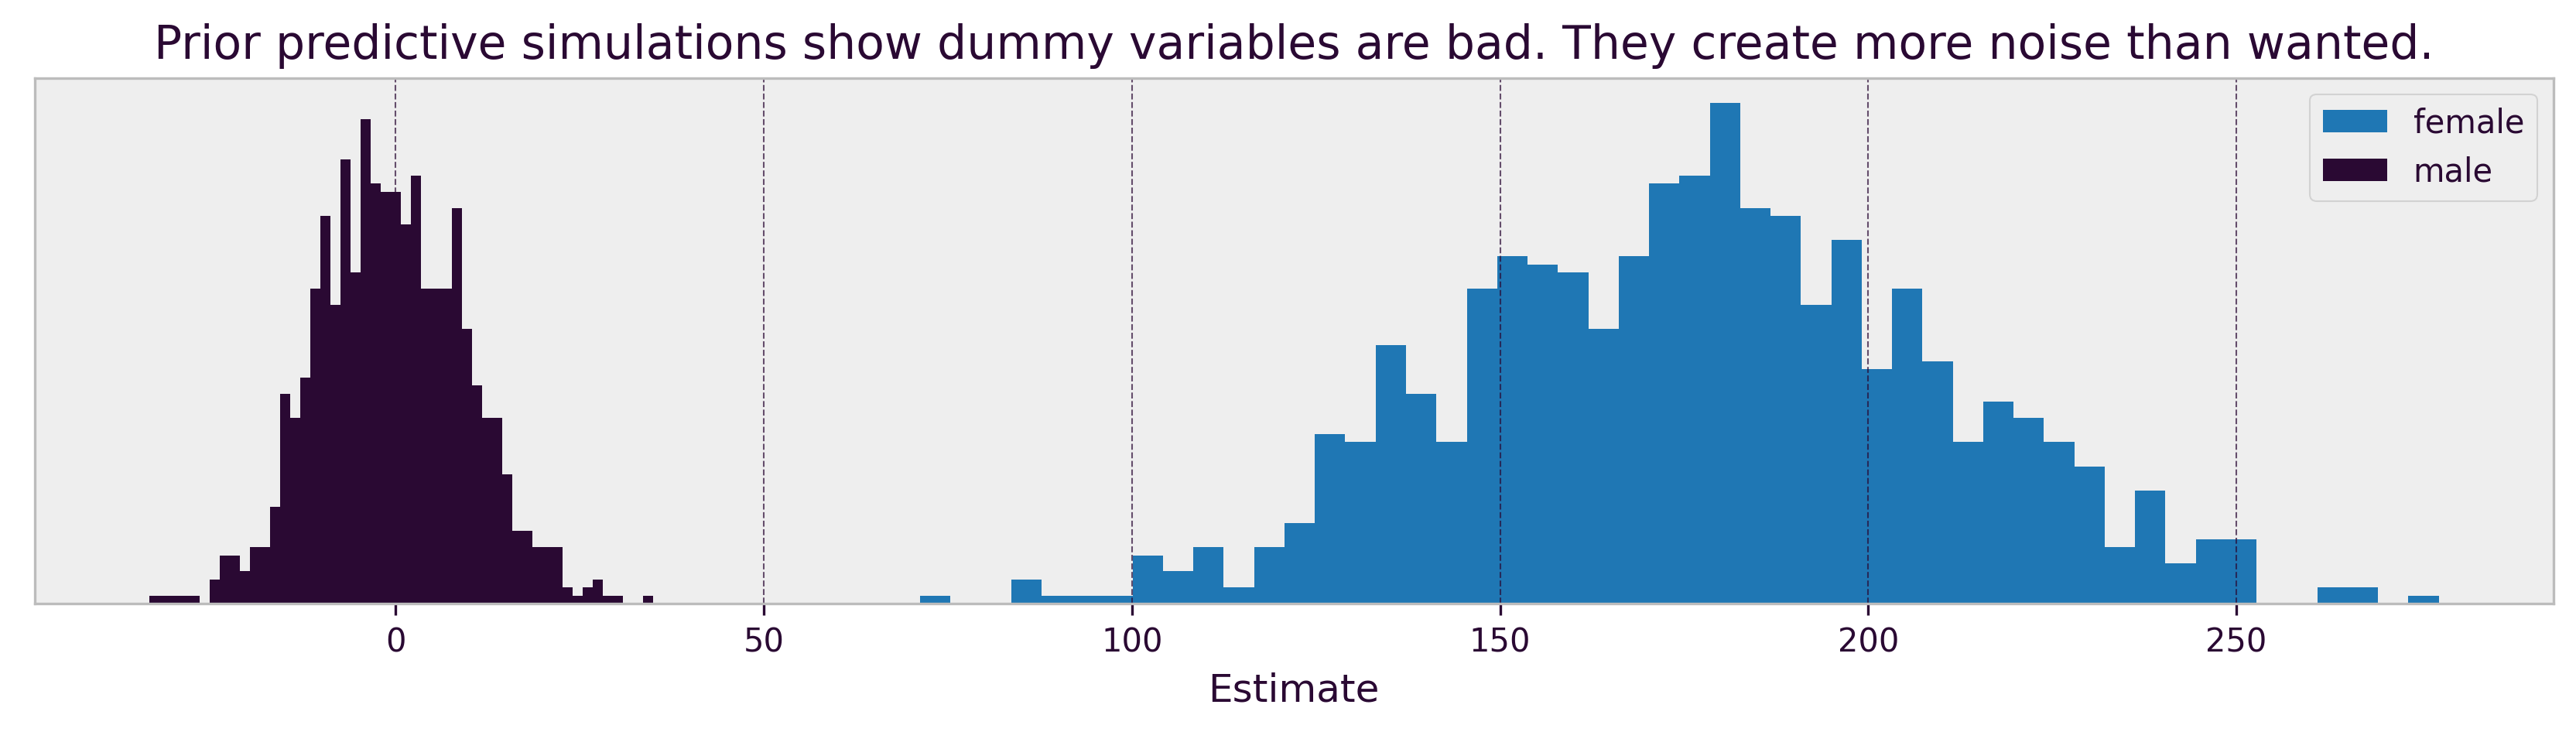

In [51]:
beta = stats.norm.rvs(0, 10, 1000)
alpha = stats.norm.rvs(178, 30, 1000)
fig, ax = plt.subplots(figsize=(14,3))
ax.hist(alpha+beta, bins=50, label = "female")
ax.hist(beta, bins=50, label = "male", color = COLOR)
ax.set_xlabel("Estimate")
ax.set_yticks([])
ax.set_title("Prior predictive simulations show dummy variables are bad. They create more noise than wanted.")
ax.legend()
plt.show()

A better thing to do is to use an index variable. This gives us an easy way to set the same level of uncertainty for each gender.


$$
height ~ normal(\mu_i, \sigma)\\
\mu_i = \alpha_{gender[i]}\\
\alpha \sim Normal(178, 30)\\
\sigma \sim Uniform(0, 50)
$$

**Python 5.47 code to Python code 5.48**

In [64]:
gender = d["male"] + 1
gender_key = {1:'female', 2:'male'}
[gender_key[g] for g in gender[:5]]

['male', 'female', 'female', 'male', 'female']

In [91]:
%%stan m5_8
data{
  int N;
  int N_genders;
  int gender[N];
  vector[N] height;
}
parameters{
  vector[N_genders] alpha;
  real<lower=0,upper=50> sigma;
}
model{  
  sigma ~ uniform(0, 50);
  alpha ~ normal(178, 20);
  for (i in 1:N) {
    height[i] ~ normal(alpha[gender[i]], sigma);
  }
}

INFO:pystan:COMPILING THE C++ CODE FOR MODEL m5_8_8df188939fc2c9c850acf0fb40e19a5c NOW.


Creating pystan model & assigning it to variable name "m5_8".
Stan options:
 {'model_name': 'm5_8', 'include_paths': None, 'boost_lib': None, 'eigen_lib': None, 'verbose': False, 'obfuscate_model_name': True}
StanModel now available as variable "m5_8"!
Compilation took 38 seconds.


In [97]:
d_dict = {
    "N": len(d.index),
    "N_genders": 2,
    "gender": gender.tolist(),
    "height": d['height'].values
}
fit_m5_8 = m5_8.sampling(d_dict, n_jobs = 4)
print(fit_m5_8.stansummary(probs=[.055, .945]))

Inference for Stan model: m5_8_8df188939fc2c9c850acf0fb40e19a5c.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   5.5%  94.5%  n_eff   Rhat
alpha[1] 134.98    0.03   1.61 132.43 137.58   3440    1.0
alpha[2] 142.54    0.03   1.69 139.79 145.19   3744    1.0
sigma     27.42    0.01   0.84  26.11  28.81   3698    1.0
lp__      -2074    0.03   1.22  -2076  -2072   1855    1.0

Samples were drawn using NUTS at Sat 18 Apr 2020 07:44:00 PM .
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


We can also compute contrasts, the difference between levels of a factor variable.

**Python code 5.49**

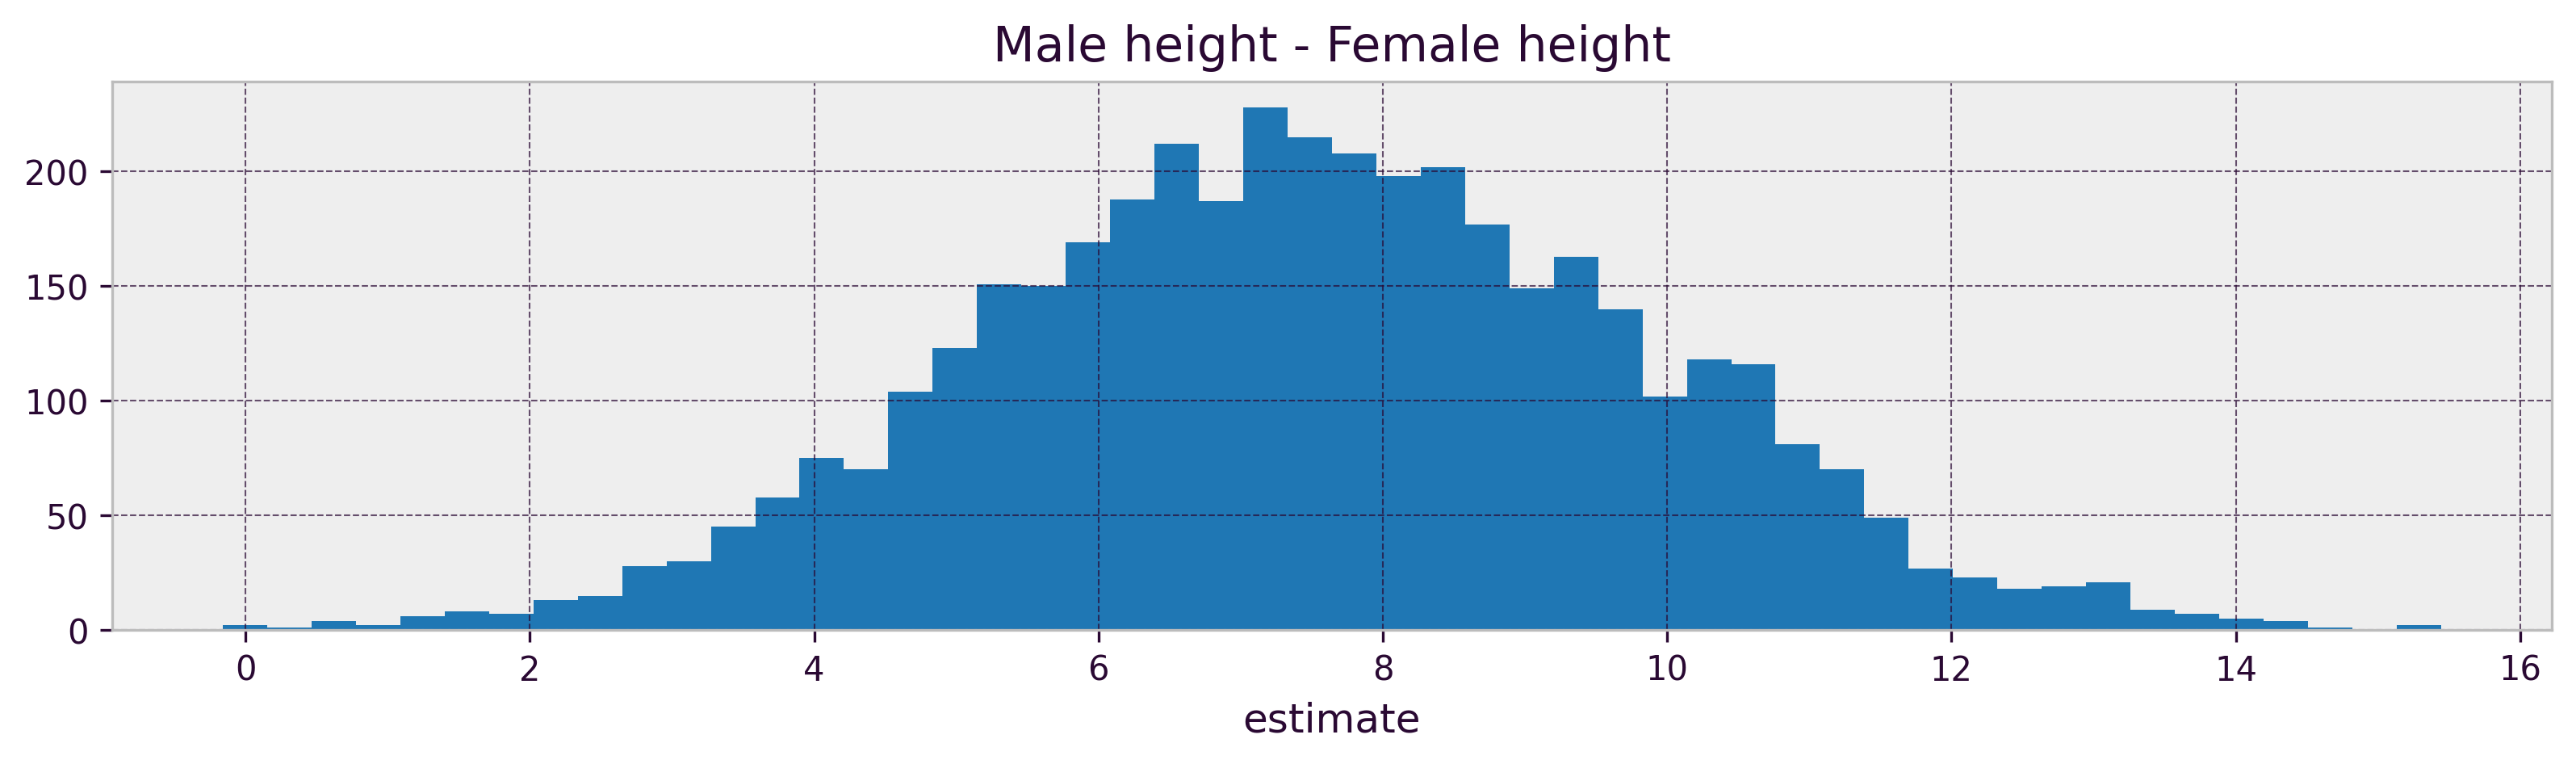

In [108]:
post = fit_m5_8.extract()
diff_mf = post['alpha'][:,1] - post['alpha'][:,0]
fig, ax = plt.subplots(figsize=(13,3))
ax.hist(diff_mf, bins = 50)
ax.set_xlabel("estimate")
ax.set_title("Male height - Female height")
plt.show()

In [83]:
d_dict = {
    "N": len(d.index),
    "n_genders": 2,
    "gender": gender.tolist(),
    "height": d['height'].values
}
m5_8.sampling(d_dict, n_jobs = 4)

Inference for Stan model: m5_8_1d9fdae0f38f1f50d86f19b1b58b48f7.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha[1]  -0.08    0.68   0.96  -1.04  -0.92  -0.35   0.81   1.44      2 355.69
alpha[2]   0.93    0.59   0.83  -0.28   0.13   1.08   1.71   1.83      2 316.45
sigma     49.99  8.8e-4   0.02  49.94  49.98  49.99   50.0   50.0    298   1.02
lp__      -4354   15.87  22.48  -4375  -4373  -4366  -4338  -4316      2  21.24

Samples were drawn using NUTS at Sat 18 Apr 2020 07:35:28 PM .
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

Not all categories are binary. Lets load a new dataset to examine many categories.

**Python code 5.5 - 5.51**

In [116]:
d = utils.data_from_R("milk", "rethinking")
clade_id = [int(e) for e in d['clade']]
kcal = utils.standardize(d['kcal.per.g'])

In [117]:
%%stan m5_9
data {
  int N;
  int N_clade;
  int clade_id[N];
  vector[N] kcal;
}
parameters {
  real<lower=0> sigma;
  vector[N_clade] alpha;
}
model {
  alpha ~ normal(0, .5);
  sigma ~ exponential(1);
  for (i in 1:N) {
    kcal[i] ~ normal(alpha[clade_id[i]], sigma);
  }
}

INFO:pystan:COMPILING THE C++ CODE FOR MODEL m5_9_55b33ead6db014e81cefe6e623843934 NOW.


Creating pystan model & assigning it to variable name "m5_9".
Stan options:
 {'model_name': 'm5_9', 'include_paths': None, 'boost_lib': None, 'eigen_lib': None, 'verbose': False, 'obfuscate_model_name': True}
StanModel now available as variable "m5_9"!
Compilation took 39 seconds.


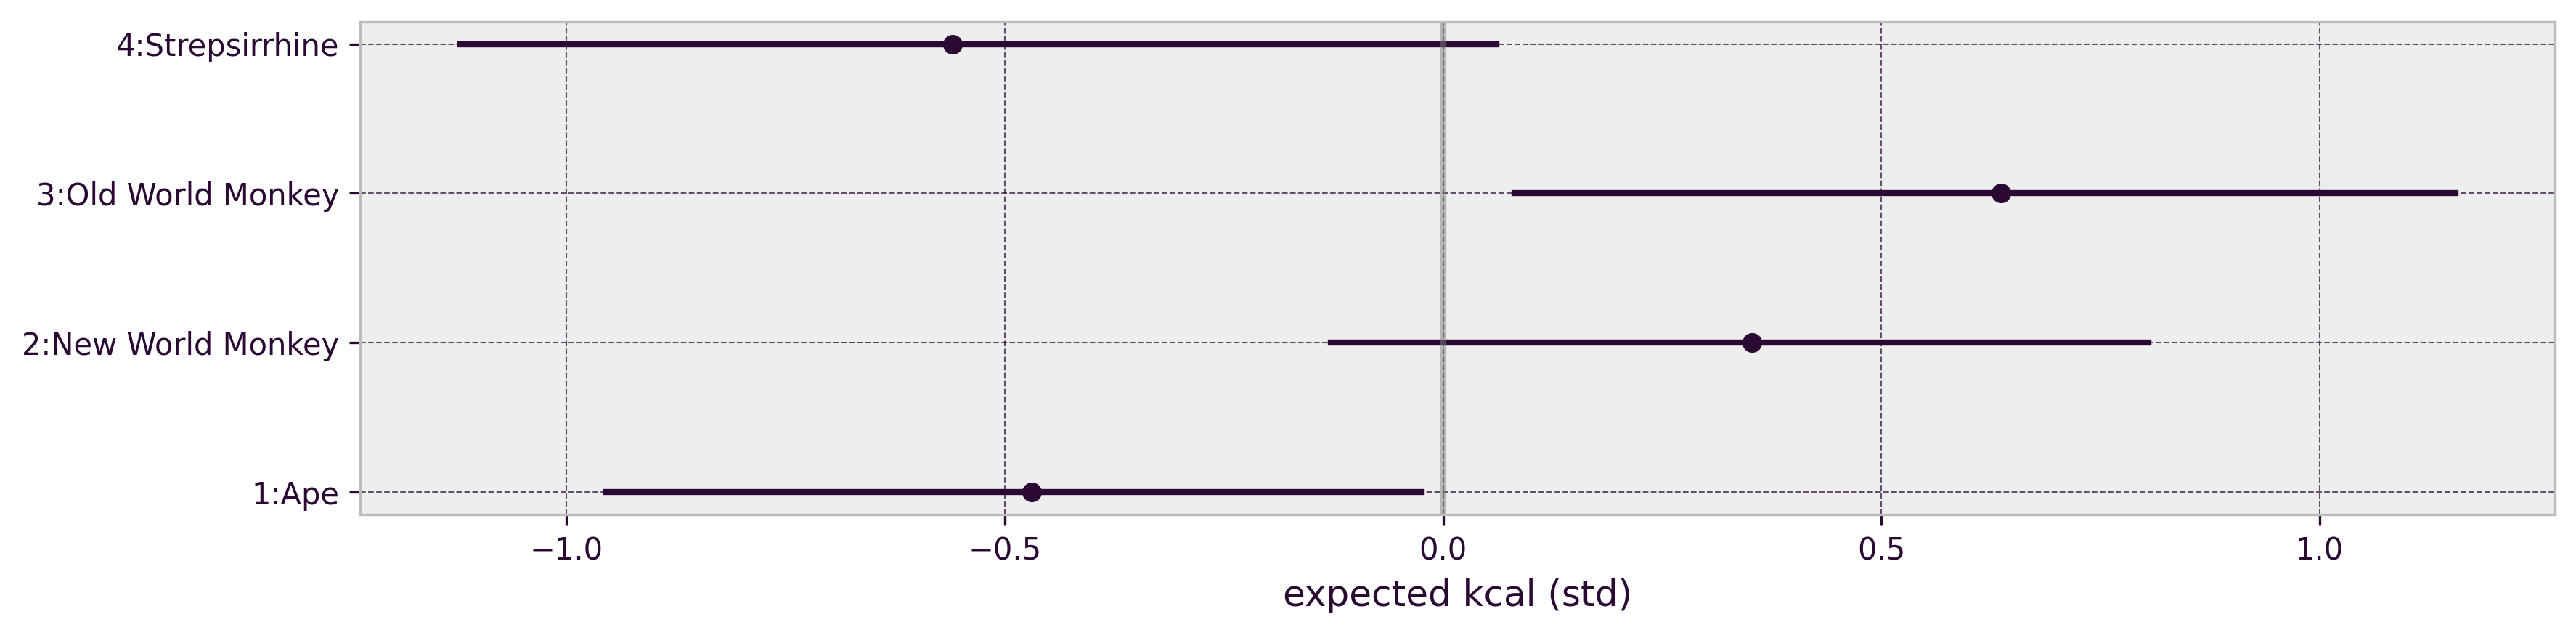

In [201]:
d_dict = {
    "N": len(d.index),
    "N_clade": max(clade_id),
    "clade_id": clade_id,
    "kcal": kcal}
fit_m5_9 = m5_9.sampling(d_dict)
post = fit_m5_9.extract()
fig, ax = plt.subplots(figsize=(13,3))
y = ["1:Ape", "2:New World Monkey", "3:Old World Monkey", "4:Strepsirrhine"]
m = np.apply_along_axis(np.mean, 0, post['alpha'])
ax.scatter(m, y, color = COLOR)
for i in range(4):
    ax.plot([x[0,i], x[1,i]],
          [y[i], y[i]],
            color = COLOR)
ax.axvline(0, color = "grey", alpha = .5)
ax.set_xlabel("expected kcal (std)")
plt.show()

Lets make up another categorical variable to showcase multiple indicies at once.

In [209]:
house = np.random.choice([1,2,3,4], size = len(d.index))
d_dict['house_id'] = house
d_dict['N_house'] = 4

In [210]:
%%stan m5_10
data {
  int N;
  int N_clade;
  int N_house;
  int clade_id[N];
  int house_id[N];
  vector[N] kcal;
}
parameters {
  real<lower=0> sigma;
  vector[N_clade] alpha;
  vector[N_house] eta;
}
model {
  alpha ~ normal(0, .5);
  sigma ~ exponential(1);
  for (i in 1:N) {
    kcal[i] ~ normal(alpha[clade_id[i]] + eta[house_id[i]], sigma);
  }
}

INFO:pystan:COMPILING THE C++ CODE FOR MODEL m5_10_2dc48c0cac5c54639c356c6378f4ec22 NOW.


Creating pystan model & assigning it to variable name "m5_10".
Stan options:
 {'model_name': 'm5_10', 'include_paths': None, 'boost_lib': None, 'eigen_lib': None, 'verbose': False, 'obfuscate_model_name': True}
StanModel now available as variable "m5_10"!
Compilation took 38 seconds.


In [211]:
m5_10.sampling(d_dict)

Inference for Stan model: m5_10_2dc48c0cac5c54639c356c6378f4ec22.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
sigma      0.83  2.7e-3   0.14   0.62   0.74   0.82   0.92   1.14   2449    1.0
alpha[1]   -0.5  9.4e-3   0.34  -1.17  -0.74  -0.51  -0.26   0.18   1339    1.0
alpha[2]   0.44  8.7e-3   0.34  -0.25   0.21   0.44   0.67   1.09   1558    1.0
alpha[3]    0.6  8.7e-3   0.35  -0.12   0.36   0.59   0.83   1.29   1656   1.01
alpha[4]   -0.5  8.1e-3   0.37  -1.21  -0.76   -0.5  -0.25   0.23   2048    1.0
eta[1]     0.36    0.01   0.41  -0.46    0.1   0.37   0.64   1.14   1458    1.0
eta[2]    -0.13    0.01    0.4  -0.92   -0.4  -0.13   0.14   0.67   1416    1.0
eta[3]     0.01    0.01   0.46  -0.86  -0.29 1.7e-3    0.3   0.93   1713    1.0
eta[4]    -0.25  9.6e-3   0.41  -1.08  -0.52  -0.25   0.03   0.53   1843    1.0
lp__     -12.91 